# Virtual Care Assistant Project Description

This notebook implements the **Virtual Care Assistant** project, which aims to monitor patients in home hospitalization by combining patient-reported symptoms and physiological vital signs (e.g., heart rate, respiratory rate, temperature, and blood pressure) to predict their medical status (improvement, deterioration, or stable(no change) ). In this project, we will:

1. Load the synthetic patient dataset from Google Drive.
2. Display the initial data to verify successful loading.
3. Compute and inspect the percentage of missing values in each column.
4. Prepare the data for downstream processing (e.g., EDA, feature engineering, and model training).


In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load data from Drive
import pandas as pd

# Make sure to update the path to the location of the file in your Drive
file_path = '/content/drive/MyDrive/patient_dataset.csv'
df = pd.read_csv(file_path)

# Display the initial data
df.head()

# Assume the DataFrame is named df_model_final
import pandas as pd

missing_summary = df.isna().mean() * 100
print("Percentage of NaN values in each column:\n", missing_summary)

Mounted at /content/drive
Percentage of NaN values in each column:
 patient_id    0.0
age           0.0
gender        0.0
diagnosis     0.0
change        0.0
day1_note     0.0
day2_note     0.0
reasoning     0.0
dtype: float64


## Initial Exploration and Preprocessing

In this section, we import the necessary libraries for data exploration, cleaning, and preprocessing before moving on to feature engineering and model training.


In [2]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


In [6]:
# Create a copy of the relevant data just for diagnosis EDA
df_diagnosis_eda = df[['diagnosis', 'change']].copy()

# Drop missing values just in case
df_diagnosis_eda = df_diagnosis_eda.dropna(subset=['diagnosis'])

#calculate the mean age
mean_age = df['age'].mean()
print("the mean age:", mean_age)
print("Mean:", df['age'].mean())
print("Std:", df['age'].std())
print("Min:", df['age'].min())
print("Max:", df['age'].max())


the mean age: 67.58512160228898
Mean: 67.58512160228898
Std: 24.981474088954613
Min: 25
Max: 110


## Function to Extract Vital Signs from Text

The `extract_all_vitals` function takes a text string (e.g., a clinical note) and uses regular expressions to find common vital sign patterns for heart rate (HR), respiratory rate (RR), temperature (Temp), and blood pressure (BP). It returns a dictionary with numeric values for each vital sign (or `NaN` if not found).


In [ ]:
import re
import numpy as np
import pandas as pd

def extract_all_vitals(text):
    text = str(text)

    # Heart Rate
    hr_match = re.search(r'HR[:=\s]*([0-9]{2,3})', text, re.IGNORECASE)

    # Respiratory Rate
    rr_match = re.search(r'RR[:=\s]*([0-9]{1,3})', text, re.IGNORECASE)

    # Temperature (with optional °C)
    temp_match = re.search(r'Temp(?:erature)?[:=\s]*([0-9]{2}(?:\.[0-9]+)?)', text, re.IGNORECASE)

    # Blood Pressure (supports formats like "120/80", "BP: 120 / 80", "BP=120/80")
    bp_match = re.search(r'BP[:=\s]*([0-9]{2,3})\s*/\s*([0-9]{2,3})', text, re.IGNORECASE)

    return {
        'HR': int(hr_match.group(1)) if hr_match else np.nan,
        'RR': int(rr_match.group(1)) if rr_match else np.nan,
        'Temp': float(temp_match.group(1)) if temp_match else np.nan,
        'BP_SYS': int(bp_match.group(1)) if bp_match else np.nan,
        'BP_DIA': int(bp_match.group(2)) if bp_match else np.nan
    }


## Calculating Differences Between Day 1 and Day 2 Vital Signs

Here, we apply the `extract_all_vitals` function to both `day1_note` and `day2_note` to extract individual vital sign values (e.g., HR, RR, Temp, BP_SYS, BP_DIA) from each day’s clinical notes. We then compute the difference (delta) between day 2 and day 1 for each vital sign. These delta features (e.g., `HR_diff`, `RR_diff`, etc.) capture changes in the patient’s condition over time and will be used as input features for our predictive models.


In [ ]:
# Extract vital signs from relevant columns (e.g., day1_note and day2_note) using the extract_all_vitals function,
# which should return a Series with columns ['HR', 'RR', 'Temp', 'BP_SYS', 'BP_DIA']

vitals_day1 = df['day1_note'].apply(extract_all_vitals).apply(pd.Series)
vitals_day2 = df['day2_note'].apply(extract_all_vitals).apply(pd.Series)

# Compute the difference between day 1 and day 2 for each vital sign (example: adjust as needed for your implementation)
df_model_vitals = pd.DataFrame({
    'HR_diff': vitals_day2['HR'] - vitals_day1['HR'],
    'RR_diff': vitals_day2['RR'] - vitals_day1['RR'],
    'Temp_diff': vitals_day2['Temp'] - vitals_day1['Temp'],
    'BP_SYS_diff': vitals_day2['BP_SYS'] - vitals_day1['BP_SYS'],
    'BP_DIA_diff': vitals_day2['BP_DIA'] - vitals_day1['BP_DIA'],
})

# Prepare the target column ('change') and combine text from day1 and day2 notes
from sklearn.preprocessing import LabelEncoder

df['combined_text'] = df['day1_note'].fillna('') + ' [SEP] ' + df['day2_note'].fillna('')
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['change'])

# Create df_model_final by concatenating text, target labels, and vital sign differences
df_model_final = pd.concat([
    df[['combined_text', 'target']].reset_index(drop=True),
    df_model_vitals.reset_index(drop=True)
], axis=1)

# Ensure df_model_final contains exactly the following columns:
# ['combined_text', 'target', 'HR_diff', 'RR_diff', 'Temp_diff', 'BP_SYS_diff', 'BP_DIA_diff']


In [ ]:
# Extract vital signs from day1 and day2 notes into separate DataFrames
vitals_day1 = df['day1_note'].apply(extract_all_vitals).apply(pd.Series)
vitals_day2 = df['day2_note'].apply(extract_all_vitals).apply(pd.Series)

# Compute the difference between day 2 and day 1 for each vital sign
vitals_diff = vitals_day2 - vitals_day1
vitals_diff.columns = [f'{col}_diff' for col in vitals_diff.columns]

# Combine original vitals and their differences into a single DataFrame
df_model_vitals = pd.concat([vitals_day1, vitals_day2, vitals_diff], axis=1)
df_model_vitals.head()


,HR,RR,Temp,BP_SYS,BP_DIA,HR,RR,Temp,BP_SYS,BP_DIA,HR_diff,RR_diff,Temp_diff,BP_SYS_diff,BP_DIA_diff
0,80.0,20.0,36.8,130.0,85.0,82.0,21.0,36.7,132.0,87.0,2.0,1.0,-0.1,2.0,2.0
1,95.0,18.0,37.5,110.0,70.0,102.0,20.0,38.0,100.0,65.0,7.0,2.0,0.5,-10.0,-5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75.0,18.0,37.0,120.0,80.0,76.0,18.0,37.1,122.0,82.0,1.0,0.0,0.1,2.0,2.0
4,80.0,18.0,36.8,130.0,85.0,82.0,19.0,36.7,128.0,84.0,2.0,1.0,-0.1,-2.0,-1.0


## Combining Text, Encoding Target, and Building Final Dataset

Here, we merge day1 and day2 notes into a single text field, encode the target labels, and concatenate all features into `df_model_final`.


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Step A: Combine notes into one text field
df['combined_text'] = df['day1_note'].fillna('') + ' [SEP] ' + df['day2_note'].fillna('')

# Step B: Encode the 'change' column into numeric target labels
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['change'])

# Step C: Concatenate text, target, and vital sign features into a single DataFrame
df_model_final = pd.concat([
    df[['combined_text', 'target']],
    df_model_vitals.reset_index(drop=True)  # extracted vitals and their differences
], axis=1)

# Display the first 5 rows
df_model_final.head()


,combined_text,target,HR,RR,Temp,BP_SYS,BP_DIA,HR,RR,Temp,BP_SYS,BP_DIA,HR_diff,RR_diff,Temp_diff,BP_SYS_diff,BP_DIA_diff
0,"Hello, today was a bit tiring but manageable. ...",2,80.0,20.0,36.8,130.0,85.0,82.0,21.0,36.7,132.0,87.0,2.0,1.0,-0.1,2.0,2.0
1,Today hasn't been too good. I've been back and...,0,95.0,18.0,37.5,110.0,70.0,102.0,20.0,38.0,100.0,65.0,7.0,2.0,0.5,-10.0,-5.0
2,"Feeling a bit lighthed, an' my mouth is pretty...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,The redness is still there and it's a bit itch...,2,75.0,18.0,37.0,120.0,80.0,76.0,18.0,37.1,122.0,82.0,1.0,0.0,0.1,2.0,2.0
4,"Feeling a bit tired today, but nothing unusual...",2,80.0,18.0,36.8,130.0,85.0,82.0,19.0,36.7,128.0,84.0,2.0,1.0,-0.1,-2.0,-1.0


In [ ]:
# Inspect the first few rows of the final dataset to verify its structure and content
df_model_final.head()

# Display information about columns, data types, and non-null counts for the DataFrame
df_model_final.info()

# Show the distribution of target labels to check class balance
df_model_final['target'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   combined_text  699 non-null    object 
 1   target         699 non-null    int64  
 2   HR             656 non-null    float64
 3   RR             658 non-null    float64
 4   Temp           654 non-null    float64
 5   BP_SYS         657 non-null    float64
 6   BP_DIA         657 non-null    float64
 7   HR             659 non-null    float64
 8   RR             660 non-null    float64
 9   Temp           655 non-null    float64
 10  BP_SYS         658 non-null    float64
 11  BP_DIA         658 non-null    float64
 12  HR_diff        656 non-null    float64
 13  RR_diff        658 non-null    float64
 14  Temp_diff      651 non-null    float64
 15  BP_SYS_diff    656 non-null    float64
 16  BP_DIA_diff    656 non-null    float64
dtypes: float64(15), int64(1), object(1)
memory usage: 93.0

,count
target,
2,260
1,220
0,219


## Text Cleaning and Spelling Correction

In this section, we install and configure SymSpell for spelling correction, define functions for basic text cleaning (removing punctuation, numbers, extra spaces), and apply SymSpell to correct spelling errors in the combined text.
#### Installing Required Packages and Advanced Text Cleaning

In this section, we install the necessary packages (SymSpell and NLTK), download NLTK stopwords, configure SymSpell for spelling correction, and define functions for:
1. Basic cleaning (lowercasing, removing numbers, punctuation, and extra spaces)
2. Spelling correction using SymSpell
3. Stopword removal using NLTK  
We then apply the full cleaning pipeline to the combined text.


In [ ]:
# Install SymSpell
!pip install -q symspellpy

In [ ]:
# Import libraries
import re, string
from symspellpy.symspellpy import SymSpell, Verbosity
import pkg_resources

# Configure SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Function for basic cleaning: remove punctuation, numbers, and extra spaces
def clean_text(text):
    if pd.isnull(text):
        return ''
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Function to correct spelling errors with SymSpell
def correct_text_symspell(text):
    words = text.split()
    corrected = []
    for word in words:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        corrected.append(suggestions[0].term if suggestions else word)
    return ' '.join(corrected)

# Combined function for full text cleaning and spelling correction
def full_clean_text(text):
    text = clean_text(text)
    text = correct_text_symspell(text)
    return text

# Create the cleaned_text column
df_model_final['cleaned_text'] = df_model_final['combined_text'].apply(full_clean_text)

# Display to verify
df_model_final[['combined_text', 'cleaned_text']].head(5)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 11.6 MB/s eta 0:00:00


,combined_text,cleaned_text
0,"Hello, today was a bit tiring but manageable. ...",hello today was a bit tiring but manageable i ...
1,Today hasn't been too good. I've been back and...,today hast been too good live been back and fo...
2,"Feeling a bit lighthed, an' my mouth is pretty...",feeling a bit lighted an my mouth is pretty dr...
3,The redness is still there and it's a bit itch...,the redness is still there and its a bit itchy...
4,"Feeling a bit tired today, but nothing unusual...",feeling a bit tired today but nothing unusual ...


In [ ]:
# Install required packages
!pip install -q symspellpy nltk

In [ ]:
# Import libraries
import pandas as pd
import re
import string
from symspellpy.symspellpy import SymSpell, Verbosity
import pkg_resources
import nltk
from nltk.corpus import stopwords

# Download NLTK English stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Configure SymSpell for spelling correction
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Basic cleaning: lowercase, remove numbers, punctuation, and extra spaces
def clean_text(text):
    if pd.isnull(text):
        return ''
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Spelling correction using SymSpell
def correct_text_symspell(text):
    words = text.split()
    corrected = []
    for word in words:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        corrected.append(suggestions[0].term if suggestions else word)
    return ' '.join(corrected)

# Remove English stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

# Full cleaning pipeline: basic cleaning → spelling correction → stopword removal
def full_clean_text(text):
    text = clean_text(text)
    text = correct_text_symspell(text)
    text = remove_stopwords(text)
    return text

# Apply the full cleaning function to the combined text
df_model_final['cleaned_text'] = df_model_final['combined_text'].apply(full_clean_text)

# Display to verify
df_model_final[['combined_text', 'cleaned_text']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,combined_text,cleaned_text
0,"Hello, today was a bit tiring but manageable. ...",hello today bit tiring manageable felt shortne...
1,Today hasn't been too good. I've been back and...,today hast good live back forth bathroom lot f...
2,"Feeling a bit lighthed, an' my mouth is pretty...",feeling bit lighted mouth pretty dry keep forg...
3,The redness is still there and it's a bit itch...,redness still bit itchy otherwise feel alright...
4,"Feeling a bit tired today, but nothing unusual...",feeling bit tired today nothing unusual taking...


## Exploratory Data Analysis and Summary Statistics

In this section, we perform a comprehensive exploratory data analysis (EDA) on `df_model_final`. We start by loading the necessary libraries and inspecting the DataFrame’s structure. We then compute summary statistics for the vital sign differences, examine the distribution of target labels, and visualize the vital deltas and text lengths. Finally, we check for missing values, calculate group‐by statistics, explore correlations, and identify outliers in the vital sign differences.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   combined_text  699 non-null    object 
 1   target         699 non-null    int64  
 2   HR             656 non-null    float64
 3   RR             658 non-null    float64
 4   Temp           654 non-null    float64
 5   BP_SYS         657 non-null    float64
 6   BP_DIA         657 non-null    float64
 7   HR             659 non-null    float64
 8   RR             660 non-null    float64
 9   Temp           655 non-null    float64
 10  BP_SYS         658 non-null    float64
 11  BP_DIA         658 non-null    float64
 12  HR_diff        656 non-null    float64
 13  RR_diff        658 non-null    float64
 14  Temp_diff      651 non-null    float64
 15  BP_SYS_diff    656 non-null    float64
 16  BP_DIA_diff    656 non-null    float64
 17  cleaned_text   699 non-null    object 
dtypes: float64

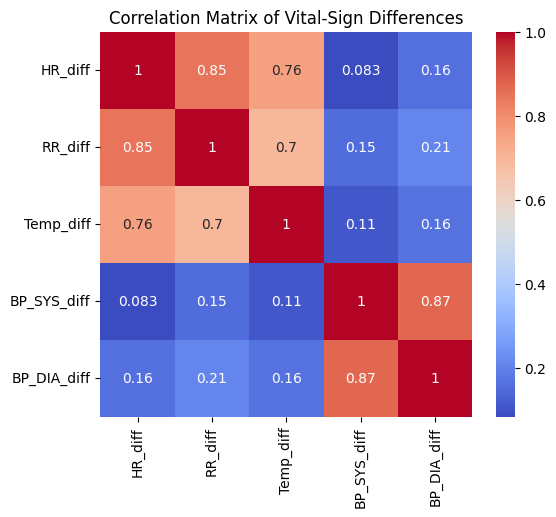

In [ ]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Inspect the first few rows and overall structure of the dataset
df_model_final.head()
df_model_final.info()

# Summary statistics for the vital-sign difference columns
vitals_diff_cols = ['HR_diff', 'RR_diff', 'Temp_diff', 'BP_SYS_diff', 'BP_DIA_diff']
df_model_final[vitals_diff_cols].describe()

# Correlation matrix among vital-sign differences
plt.figure(figsize=(6, 5))
corr_matrix = df_model_final[vitals_diff_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Vital-Sign Differences')
plt.show()


### Correlation Analysis of Vital-Sign Deltas

**What we examined:**  
We analyzed the correlations between day-to-day changes in vital signs (`HR_diff`, `RR_diff`, `Temp_diff`, `BP_SYS_diff`, `BP_DIA_diff`) to detect redundancy or strong co-dependencies between features.

**Key insight:**  
- Strong positive correlations were found between **HR_diff & RR_diff (0.85)** and **BP_SYS_diff & BP_DIA_diff (0.87)**, indicating physiological coupling between respiratory and cardiovascular parameters.


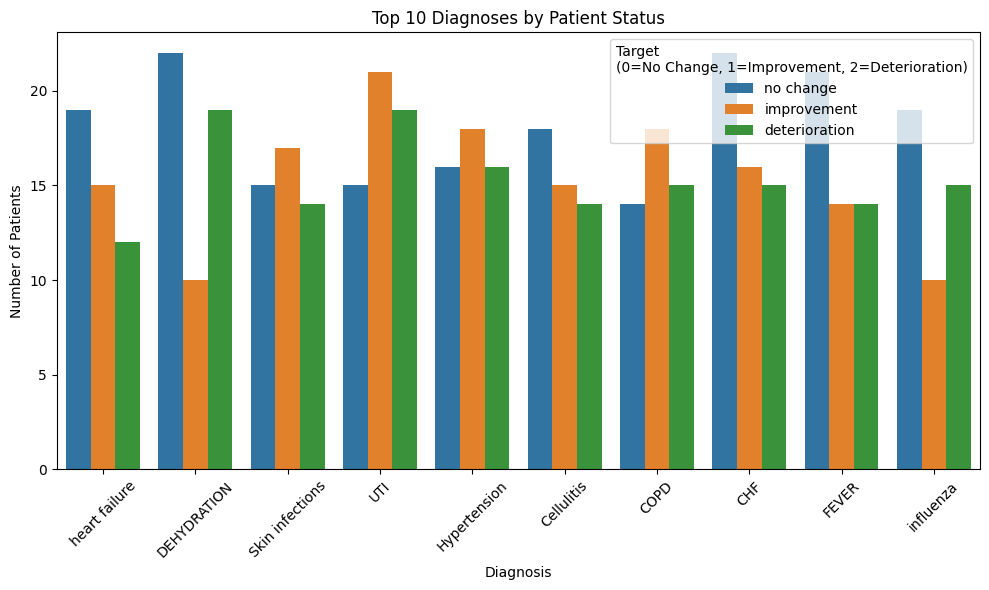

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Diagnosis distribution by patient status (target) – using original df with 'diagnosis' column

# Check top 10 diagnoses
top_diagnoses = df_diagnosis_eda['diagnosis'].value_counts().nlargest(10).index

# Filter to top 10 only
df_diag_filtered = df_diagnosis_eda[df_diagnosis_eda['diagnosis'].isin(top_diagnoses)]

# Plot countplot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_diag_filtered, x='diagnosis', hue='change')
plt.title('Top 10 Diagnoses by Patient Status')
plt.xlabel('Diagnosis')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.legend(title='Target\n(0=No Change, 1=Improvement, 2=Deterioration)')
plt.tight_layout()
plt.show()

### Diagnoses by Patient Status

**What we examined:**  
We analyzed the top 10 most common diagnoses and compared how their clinical outcomes (`target`) are distributed across `no change`, `improvement`, and `deterioration`.

**Key insight:**  
- Certain diagnoses, such as **heart failure** and **dehydration**, are associated with a higher proportion of deterioration.  
- In contrast, conditions like **UTI** and **COPD** more frequently end in improvement, suggesting different clinical recovery profiles per diagnosis.

Label Distribution:
 target
2    260
1    220
0    219
Name: count, dtype: int64


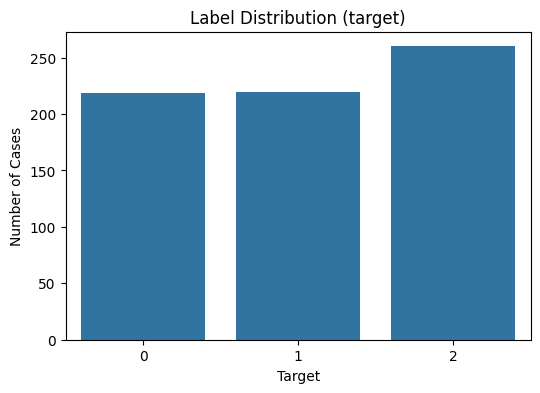

In [ ]:
# Display the count of each label and plot its distribution
label_counts = df_model_final['target'].value_counts()
print("Label Distribution:\n", label_counts)

plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df_model_final)
plt.title('Label Distribution (target)')
plt.xlabel('Target')
plt.ylabel('Number of Cases')
plt.show()

### Label Distribution Analysis

**What we examined:**  
We analyzed the distribution of the `target` labels to ensure class balance and check for any potential bias in classification.

**Key insight:**  
- The dataset is relatively balanced across all three labels:  
  `0 = No Change (219)`, `1 = Improvement (220)`, `2 = Deterioration (260)`,  
  which supports fair training for multi-class classification.


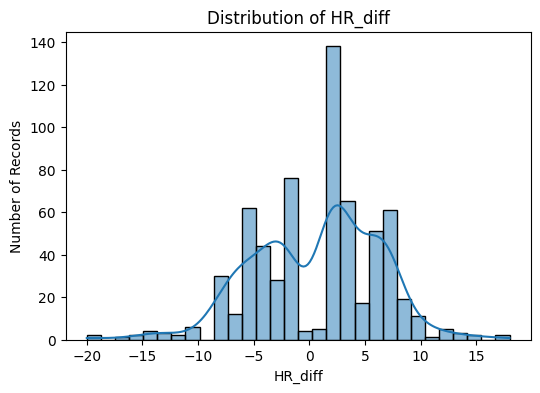

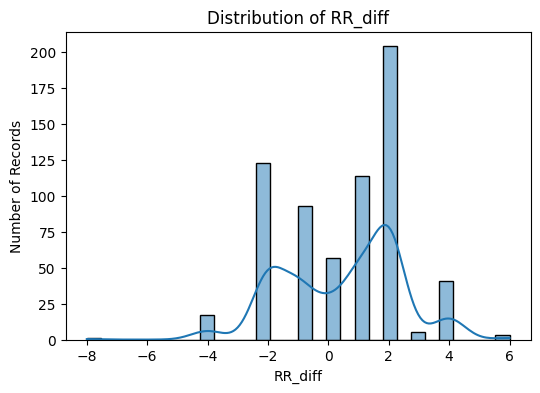

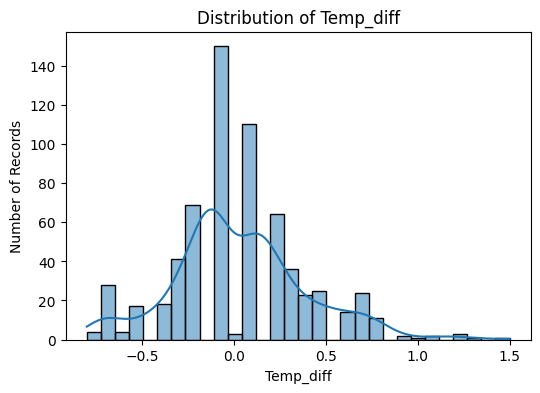

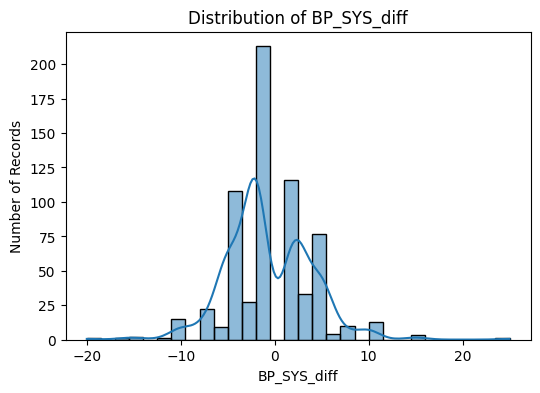

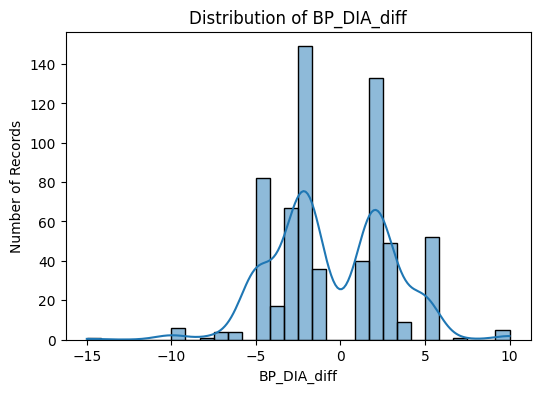

In [ ]:
# Plot histograms (with KDE) for each vital-sign difference
for col in vitals_diff_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_model_final[col].dropna(), bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Number of Records')
    plt.show()

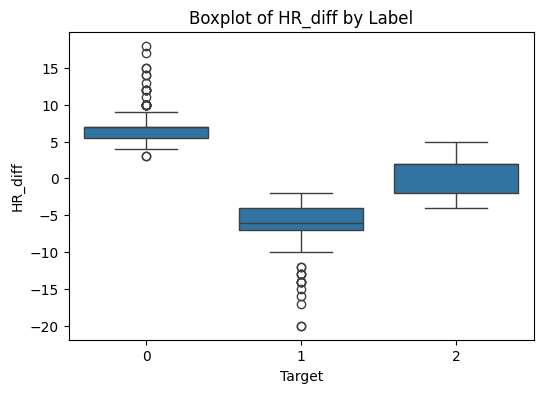

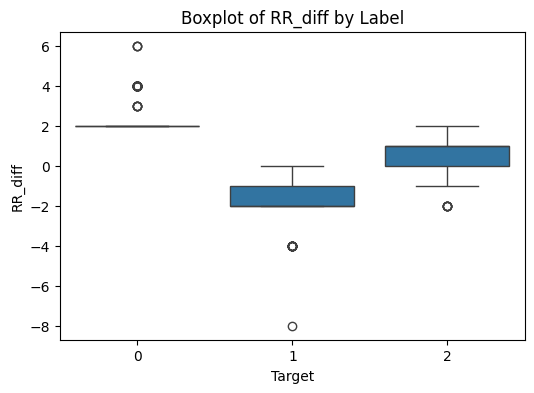

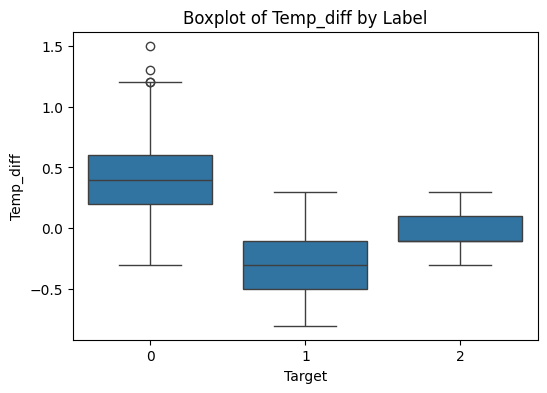

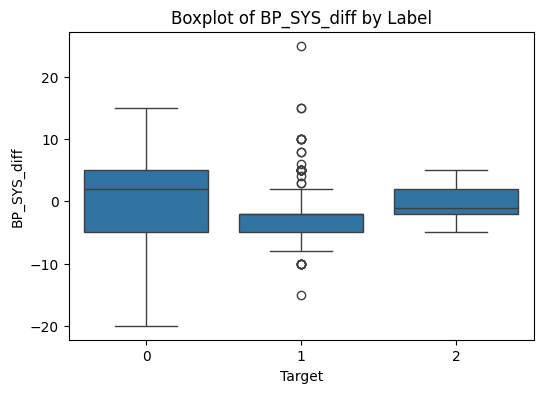

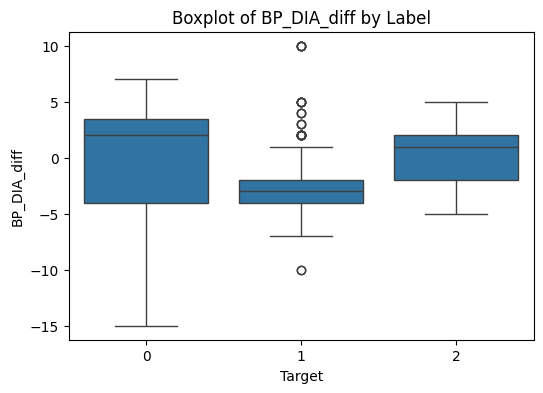

In [ ]:
# Plot boxplots of each vital-sign difference by label
for col in vitals_diff_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='target', y=col, data=df_model_final)
    plt.title(f'Boxplot of {col} by Label')
    plt.xlabel('Target')
    plt.ylabel(col)
    plt.show()

### Distribution & Grouped Analysis of Vital-Sign Deltas

**What we examined:**  
We explored the value distributions of each vital-sign delta (e.g., `HR_diff`, `RR_diff`) to detect skewness, outliers, and differences between clinical outcome classes (`target`).

**Key insight:**  
- Histograms show centered and symmetric distributions, supporting realistic simulation.  
- Boxplots reveal that improvement cases (`target = 1`) are often associated with decreases in vitals, while deterioration (`target = 2`) tends to align with increases, especially for `HR_diff` and `RR_diff`.

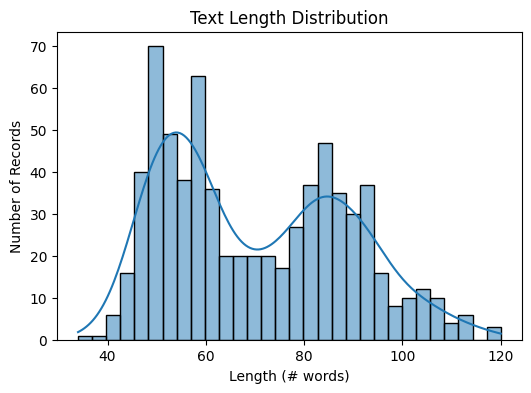

In [ ]:
# Calculate and plot text length distribution
df_model_final['text_length'] = df_model_final['combined_text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(6, 4))
sns.histplot(df_model_final['text_length'], bins=30, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Length (# words)')
plt.ylabel('Number of Records')
plt.show()

### Text Length Distribution

**What we examined:**  
We analyzed the distribution of free-text report lengths (in number of words) to understand input variability and guide preprocessing decisions such as truncation or padding for NLP models.

**Key insight:**  
- Most texts contain between **40–100 words**, with a mild bi-modal distribution.  
- This supports setting the maximum token length around 120 for safe padding during model training.

In [ ]:
# Count and percentage of missing values for each vital-sign difference
missing_counts = df_model_final[vitals_diff_cols].isnull().sum()
print("Missing values per vital-sign difference:\n", missing_counts)

missing_pct = df_model_final[vitals_diff_cols].isnull().mean() * 100
print("Missing percentage per vital-sign difference:\n", missing_pct)

# Group‐by statistics for vital-sign differences by label
grouped_stats = df_model_final.groupby('target')[vitals_diff_cols].agg(['count', 'mean', 'std', 'min', 'max'])
print("Vital-Sign Difference Statistics by Label:\n", grouped_stats)


Missing values per vital-sign difference:
 HR_diff        43
RR_diff        41
Temp_diff      48
BP_SYS_diff    43
BP_DIA_diff    43
dtype: int64
Missing percentage per vital-sign difference:
 HR_diff        6.151645
RR_diff        5.865522
Temp_diff      6.866953
BP_SYS_diff    6.151645
BP_DIA_diff    6.151645
dtype: float64
Vital-Sign Difference Statistics by Label:
        HR_diff                                 RR_diff                      \
         count      mean       std   min   max   count      mean       std   
target                                                                       
0          207  6.739130  2.397322   3.0  18.0     209  2.473684  0.904331   
1          203 -5.955665  3.193900 -20.0  -2.0     203 -1.817734  0.975583   
2          246  0.902439  2.089486  -4.0   5.0     246  0.634146  1.008278   

                  ... BP_SYS_diff                                 BP_DIA_diff  \
        min  max  ...       count      mean       std   min   max       count 

<ipython-input-18-35412307>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='text_length', data=df_model_final, palette='Set2')


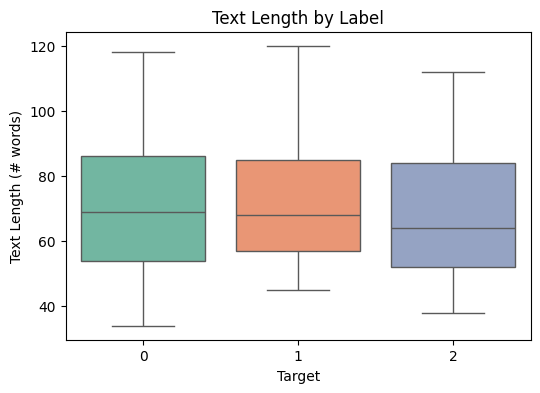

<ipython-input-18-35412307>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='target', y='text_length', data=df_model_final, inner='quartile', palette='Set2')


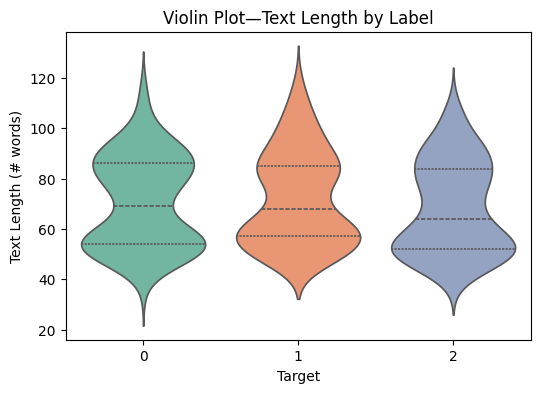

In [ ]:
# Boxplot and violin plot of text length by label
plt.figure(figsize=(6, 4))
sns.boxplot(x='target', y='text_length', data=df_model_final, palette='Set2')
plt.title('Text Length by Label')
plt.xlabel('Target')
plt.ylabel('Text Length (# words)')
plt.show()

plt.figure(figsize=(6, 4))
sns.violinplot(x='target', y='text_length', data=df_model_final, inner='quartile', palette='Set2')
plt.title('Violin Plot—Text Length by Label')
plt.xlabel('Target')
plt.ylabel('Text Length (# words)')
plt.show()


### Text Length by Clinical Outcome (Target)

**What we examined:**  
We compared text lengths across the different `target` labels (0 = No Change, 1 = Improvement, 2 = Deterioration) to assess whether report verbosity differs by clinical status.

**Key insight:**  
- Median lengths are similar across labels, but **"no change" texts tend to be slightly longer and more varied**.  
- Violin plots show **multi-modal patterns** in all classes, reflecting varied reporting styles among simulated patients.


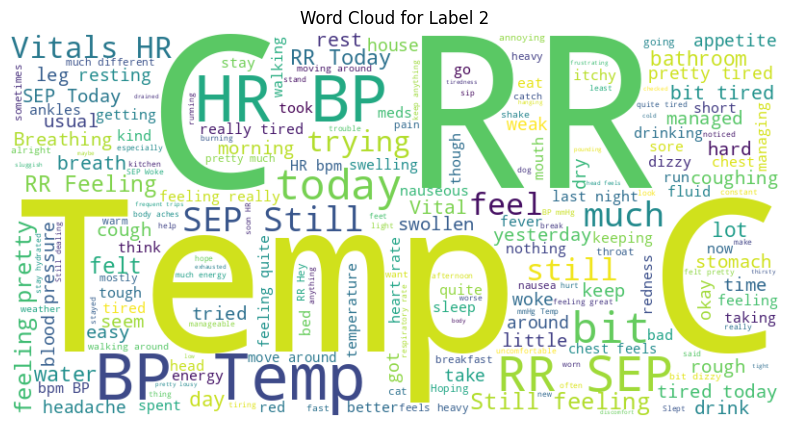

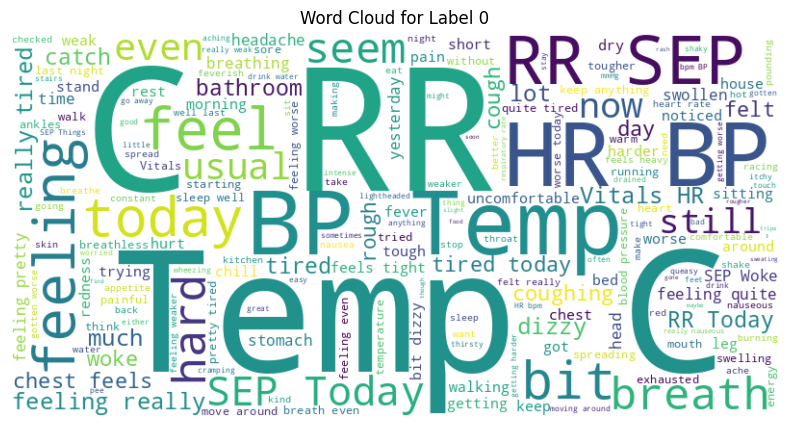

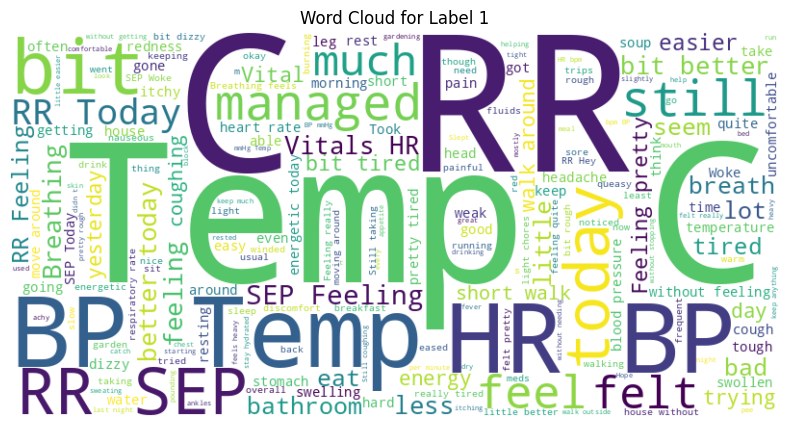

In [ ]:
# Generate word clouds for each label
for label in df_model_final['target'].unique():
    texts = df_model_final[df_model_final['target'] == label]['combined_text'].dropna()
    combined_text = " ".join(texts.tolist())
    wc = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Label {label}')
    plt.show()

### Word Clouds by Clinical Status

**What we examined:**  
We visualized the most frequent words in free-text reports, separated by target label (`0 = No Change`, `1 = Improvement`, `2 = Deterioration`), to explore linguistic patterns unique to each outcome.

**Key insight:**  
- Common physiological terms like `RR`, `BP`, and `Temp` appear across all classes.
- Patients showing deterioration tend to use more urgent and negative expressions (`weak`, `hard`, `swollen`), while improvement texts include more positive terms (`managed`, `better`, `felt good`).

In [ ]:
# Identify and display top 5 extreme values for each vital-sign difference
for col in vitals_diff_cols:
    print(f"=== Top 5 highest {col} values ===")
    print(df_model_final.nlargest(5, col)[['target', col, 'combined_text']], "\n")
    print(f"=== Top 5 lowest {col} values ===")
    print(df_model_final.nsmallest(5, col)[['target', col, 'combined_text']], "\n")
    print("-" * 80)

=== Top 5 highest HR_diff values ===
     target  HR_diff                                      combined_text
389       0     18.0  I seem to be feeling well at the starting, but...
491       0     17.0  I fell not good today, blury vision and dizyz....
33        0     15.0  I woke up feeling queasy and spent most of the...
43        0     15.0  Hey, just checking in. Today my skin feels rea...
306       0     14.0  The redness in my leg has gotten pretty bad, a... 

=== Top 5 lowest HR_diff values ===
     target  HR_diff                                      combined_text
42        1    -20.0  I'm feeling quit tired today, cough very persi...
295       1    -20.0  I’ve been feeling really tired and couldn’t do...
677       1    -17.0  I've been feeling really tired and my mouth is...
688       1    -16.0  I feel not good today stomach is turning turri...
396       1    -15.0  Yesterday was tough. I felt really dizzy and l... 

-----------------------------------------------------------

In [ ]:
# Calculate Pearson correlation between each vital-sign difference and the target
corr_with_target = df_model_final[vitals_diff_cols + ['target']].corr()['target'].drop('target')
print("Pearson correlation of vital-sign differences with target:\n", corr_with_target)

# Impute missing values in vital-sign differences with column means
for col in vitals_diff_cols:
    df_model_final[col] = df_model_final[col].fillna(df_model_final[col].mean())

# Verify that no missing values remain in the vital-sign difference columns
print("After imputation, missing counts per vital-sign difference column:")
print(df_model_final[vitals_diff_cols].isnull().sum())

Pearson correlation of vital-sign differences with target:
 HR_diff       -0.390456
RR_diff       -0.353939
Temp_diff     -0.451934
BP_SYS_diff    0.029776
BP_DIA_diff    0.047146
Name: target, dtype: float64
After imputation, missing counts per vital-sign difference column:
HR_diff        0
RR_diff        0
Temp_diff      0
BP_SYS_diff    0
BP_DIA_diff    0
dtype: int64


In [ ]:
# Print the names of the vital-sign difference columns
print("vitals_diff_cols:", vitals_diff_cols)
# Print all column names in df_model_final to verify that vital-sign columns exist
print("df_model_final.columns:", df_model_final.columns.tolist())


vitals_diff_cols: ['HR_diff', 'RR_diff', 'Temp_diff', 'BP_SYS_diff', 'BP_DIA_diff']
df_model_final.columns: ['combined_text', 'target', 'HR', 'RR', 'Temp', 'BP_SYS', 'BP_DIA', 'HR', 'RR', 'Temp', 'BP_SYS', 'BP_DIA', 'HR_diff', 'RR_diff', 'Temp_diff', 'BP_SYS_diff', 'BP_DIA_diff', 'cleaned_text', 'text_length']


## Splitting Data into Train+Validation and Test Sets

In this step, we separate 90% of the data (for training and validation) from 10% reserved for testing. We perform a stratified split to preserve the label distribution in both subsets.


In [ ]:
from sklearn.model_selection import train_test_split

# Define feature and target arrays
X_text   = df_model_final['combined_text']
X_vitals = df_model_final[vitals_diff_cols].values
y        = df_model_final['target'].values

# Perform a stratified 90%/10% split
X_text_trainval, X_text_test, \
X_vitals_trainval, X_vitals_test, \
y_trainval, y_test = train_test_split(
    X_text, X_vitals, y,
    stratify=y,
    test_size=0.10,
    random_state=42
)

print("Train+Validation size:", len(y_trainval))
print("Test size:            ", len(y_test))
print("Label distribution in Train+Validation:", np.bincount(y_trainval) / y_trainval.shape[0])
print("Label distribution in Test:            ", np.bincount(y_test) / y_test.shape[0])


Train+Validation size: 629
Test size:             70
Label distribution in Train+Validation: [0.31319555 0.31478537 0.37201908]
Label distribution in Test:             [0.31428571 0.31428571 0.37142857]


## Splitting Train+Validation into Final Train and Validation Sets

In this step, we further split the 90% training+validation set into 80% for training and 20% for validation, maintaining stratified label distribution.


In [ ]:
#Split the 90% into 80% Train and 20% Val
X_text_train, X_text_val, \
X_vitals_train, X_vitals_val, \
y_train, y_val = train_test_split(
    X_text_trainval, X_vitals_trainval, y_trainval,
    stratify=y_trainval,
    test_size=0.20,  #Approximately 20% of the 90% subset
    random_state=42
)

print("Final Train size:", len(y_train))
print("Final Val size:  ", len(y_val))
print("Label dist Train:", np.bincount(y_train)/y_train.shape[0])
print("Label dist Val:  ", np.bincount(y_val)/y_val.shape[0])


Final Train size: 503
Final Val size:   126
Label dist Train: [0.31411531 0.31411531 0.37176938]
Label dist Val:   [0.30952381 0.31746032 0.37301587]


## BERT Tokenization of Text Data

In this section, we load a BERT tokenizer, define a function to convert raw text into input IDs and attention masks, and then apply it to the train, validation, and test text sets.


In [ ]:
# Load BERT tokenizer
from transformers import BertTokenizer

MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
max_len = 128  # Maximum token length for each sequence

def tokenize_texts(texts, tokenizer, max_len):
    """
    Tokenize a list of text strings using the specified tokenizer.
    Returns input IDs and attention masks.
    """
    encoded = tokenizer.batch_encode_plus(
        texts.tolist(),
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    return encoded['input_ids'], encoded['attention_mask']

# Tokenize train, validation, and test text data
X_ids_train, X_mask_train = tokenize_texts(X_text_train, tokenizer, max_len)
X_ids_val,   X_mask_val   = tokenize_texts(X_text_val,   tokenizer, max_len)
X_ids_test,  X_mask_test  = tokenize_texts(X_text_test,  tokenizer, max_len)

# Display shapes to confirm successful tokenization
print("Train input_ids shape:",  X_ids_train.shape, " attention_mask shape:", X_mask_train.shape)
print("Val   input_ids shape:",  X_ids_val.shape,   " attention_mask shape:", X_mask_val.shape)
print("Test  input_ids shape:",  X_ids_test.shape,  " attention_mask shape:", X_mask_test.shape)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Train input_ids shape: (503, 128)  attention_mask shape: (503, 128)
Val   input_ids shape: (126, 128)  attention_mask shape: (126, 128)
Test  input_ids shape: (70, 128)  attention_mask shape: (70, 128)


## Scaling Vital-Sign Difference Features

Here, we use `StandardScaler` to standardize the vital-sign difference features so that each feature has zero mean and unit variance. We fit the scaler on the training data and apply the same transformation to the validation and test sets.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training vital-sign differences and transform
X_vitals_train_scaled = scaler.fit_transform(X_vitals_train)

# Apply the same scaling to validation and test sets
X_vitals_val_scaled   = scaler.transform(X_vitals_val)
X_vitals_test_scaled  = scaler.transform(X_vitals_test)

# Display the shapes of the scaled arrays
print("Vitals shapes (scaled):")
print(" Train:", X_vitals_train_scaled.shape)
print(" Val:  ", X_vitals_val_scaled.shape)
print(" Test: ", X_vitals_test_scaled.shape)


Vitals shapes (scaled):
 Train: (503, 5)
 Val:   (126, 5)
 Test:  (70, 5)


## Baseline and Fusion Modeling, Model Training and Evaluation with Results Tracking

In this section, we:
1. Initialize a results list to store performance metrics.
2. Build and evaluate a baseline model on raw text using TF-IDF and Logistic Regression.
3. Build and evaluate a baseline model on cleaned text.
4. Construct a fusion model that combines TF-IDF text features with standardized vital-sign difference features, and evaluate it.
5. Append each model’s accuracy and macro-F1 scores to the `results` list.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate

# ===========================
# 1. Create an empty list to store results
# ===========================
results = []

# Raw and cleaned text features, plus labels
X_raw   = df_model_final['combined_text']
X_clean = df_model_final['cleaned_text']
y       = df_model_final['target']

# Function to build a TF-IDF + Logistic Regression pipeline
def build_text_pipeline():
    return Pipeline([
        ('tfidf', TfidfVectorizer(max_features=500, ngram_range=(1,2))),
        ('clf',   LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
    ])

# Set up stratified 5-fold cross-validation and evaluation metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1_macro']

# ===========================
# 2. Baseline Model on Raw Text
# ===========================
print("Baseline Model on Raw Text (entire dataset):")
raw_results = cross_validate(
    build_text_pipeline(),   # pipeline definition
    X_raw,                   # uncleaned text
    y,                       # labels
    scoring=scoring,
    cv=cv
)
# Compute mean scores
raw_acc = raw_results['test_accuracy'].mean()
raw_f1  = raw_results['test_f1_macro'].mean()

print(f"  Accuracy (mean over 5 folds): {raw_acc:.4f}")
print(f"  Macro-F1  (mean over 5 folds): {raw_f1:.4f}\n")

# Add raw text baseline results to the results list
results.append({
    'model':    'Baseline_RawText',
    'accuracy': raw_acc,
    'f1_macro': raw_f1
})

# ===========================
# 3. Baseline Model on Cleaned Text
# ===========================
print("Baseline Model on Cleaned Text (entire dataset):")
clean_results = cross_validate(
    build_text_pipeline(),   # same pipeline as above
    X_clean,                 # cleaned text
    y,                       # labels
    scoring=scoring,
    cv=cv
)
# Compute mean scores
clean_acc = clean_results['test_accuracy'].mean()
clean_f1  = clean_results['test_f1_macro'].mean()

print(f"  Accuracy (mean over 5 folds): {clean_acc:.4f}")
print(f"  Macro-F1  (mean over 5 folds): {clean_f1:.4f}\n")

# Add cleaned text baseline results to the results list
results.append({
    'model':    'Baseline_CleanText',
    'accuracy': clean_acc,
    'f1_macro': clean_f1
})

# ===========================
# 4. Fusion Model: Text + Vital-Sign Differences
# ===========================
vitals_diff_cols = ['HR_diff', 'RR_diff', 'Temp_diff', 'BP_SYS_diff', 'BP_DIA_diff']

# Create DataFrame combining text and vital-sign difference features
X_fusion = pd.DataFrame({
    'combined_text': df_model_final['combined_text'],
    'HR_diff':       df_model_final['HR_diff'],
    'RR_diff':       df_model_final['RR_diff'],
    'Temp_diff':     df_model_final['Temp_diff'],
    'BP_SYS_diff':   df_model_final['BP_SYS_diff'],
    'BP_DIA_diff':   df_model_final['BP_DIA_diff']
})
y_fusion = df_model_final['target']

# Define preprocessor: TF-IDF on text, impute + scale on vital differences
preprocessor = ColumnTransformer(transformers=[
    ('text',   TfidfVectorizer(max_features=500, ngram_range=(1,2)), 'combined_text'),
    ('vitals', Pipeline([
        ('imputer', SimpleImputer()),       # fill missing vital differences if any
        ('scaler',  StandardScaler())
    ]), vitals_diff_cols)
])

# Build the fusion pipeline: preprocessing + Logistic Regression
fusion_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',   LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Evaluate the fusion model with stratified 5-fold cross-validation
print("Fusion Model (Text + vital differences) on entire dataset:")
fusion_results = cross_validate(
    fusion_pipeline,
    X_fusion,
    y_fusion,
    cv=cv,
    scoring=['accuracy', 'f1_macro'],
    return_train_score=False
)
# Compute mean scores
fusion_acc = fusion_results['test_accuracy'].mean()
fusion_f1  = fusion_results['test_f1_macro'].mean()

print(f"  Accuracy (mean over 5 folds): {fusion_acc:.4f}")
print(f"  Macro-F1  (mean over 5 folds): {fusion_f1:.4f}")

# Add fusion model results to the results list
results.append({
    'model':    'Fusion_Text+Vitals',
    'accuracy': fusion_acc,
    'f1_macro': fusion_f1
})

Baseline Model on Raw Text (entire dataset):
  Accuracy (mean over 5 folds): 0.9514
  Macro-F1  (mean over 5 folds): 0.9513

Baseline Model on Cleaned Text (entire dataset):
  Accuracy (mean over 5 folds): 0.8956
  Macro-F1  (mean over 5 folds): 0.8965

Fusion Model (Text + vital differences) on entire dataset:
  Accuracy (mean over 5 folds): 0.9485
  Macro-F1  (mean over 5 folds): 0.9493


## Data Splitting, Fusion Model Training, and Evaluation

In this section, we:
1. Import required libraries and initialize the `results` .
2. Create feature (`X_all`) and target (`y_all`) datasets from `df_model_final`.
3. Perform a stratified 70% train+validation / 30% test split.
4. Separate text and vital-sign difference features within each split.
5. Define and configure the Fusion pipeline (TF-IDF on text + impute & scale on vital-sign deltas).
6. Build a DataFrame for the train+validation subset and evaluate the Fusion pipeline using stratified 5-fold cross-validation.
7. Train the Fusion model on the entire train+validation set.
8. Build a DataFrame for the test subset and generate predictions.
9. Compute and display test-set accuracy and macro-F1.
10. Append both CV and test results to the `results` list.


In [ ]:
# --------------------------------------
# 1. Import libraries and reset `results`
# --------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# If `results` is not already defined, create it
results = []

# List of vital-sign difference columns
vitals_diff_cols = ['HR_diff', 'RR_diff', 'Temp_diff', 'BP_SYS_diff', 'BP_DIA_diff']

# --------------------------------------
# 2. Build X_all and y_all from df_model_final
# --------------------------------------
# (Assumes df_model_final contains columns:
# 'combined_text', 'HR_diff', 'RR_diff', 'Temp_diff', 'BP_SYS_diff', 'BP_DIA_diff', 'target')
X_all = pd.DataFrame({
    'combined_text': df_model_final['combined_text'],
    'HR_diff':       df_model_final['HR_diff'],
    'RR_diff':       df_model_final['RR_diff'],
    'Temp_diff':     df_model_final['Temp_diff'],
    'BP_SYS_diff':   df_model_final['BP_SYS_diff'],
    'BP_DIA_diff':   df_model_final['BP_DIA_diff']
})
y_all = df_model_final['target']

# --------------------------------------
# 3. Stratified split (70% Train+Val, 30% Test)
# --------------------------------------
X_trainval_all, X_test_all, y_trainval, y_test = train_test_split(
    X_all,
    y_all,
    test_size=0.30,
    stratify=y_all,
    random_state=42
)

# --------------------------------------
# 4. Split X_trainval_all into X_text_trainval and X_vitals_trainval
# --------------------------------------
X_text_trainval   = X_trainval_all['combined_text'].reset_index(drop=True)
X_vitals_trainval = X_trainval_all[vitals_diff_cols].values

# --------------------------------------
# 5. Split X_test_all into X_text_test and X_vitals_test
# --------------------------------------
X_text_test   = X_test_all['combined_text'].reset_index(drop=True)
X_vitals_test = X_test_all[vitals_diff_cols].values

# --------------------------------------
# 6. Verify shapes after splitting
# --------------------------------------
print("Shapes after split:")
print("  X_text_trainval:    ", X_text_trainval.shape)
print("  X_vitals_trainval:  ", X_vitals_trainval.shape)
print("  y_trainval:         ", y_trainval.shape)
print("  X_text_test:        ", X_text_test.shape)
print("  X_vitals_test:      ", X_vitals_test.shape)
print("  y_test:             ", y_test.reset_index(drop=True).shape)

# Note: After resetting indices, y_test should have length equal to the test set (e.g., 30% of original).

# --------------------------------------
# 7. Import additional libraries for modeling
# --------------------------------------
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score

# --------------------------------------
# 8. Define ColumnTransformer and Fusion Pipeline
# --------------------------------------
preprocessor = ColumnTransformer(transformers=[
    (
        'text',
        TfidfVectorizer(max_features=500, ngram_range=(1,2)),
        'combined_text'
    ),
    (
        'vitals',
        Pipeline([
            ('imputer', SimpleImputer()),    # Impute missing vital-sign differences
            ('scaler',  StandardScaler())     # Scale numeric features
        ]),
        vitals_diff_cols
    )
])

fusion_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    (
        'classifier',
        LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    )
])

# --------------------------------------
# 9. Build DataFrame for Train+Val and evaluate via Stratified 5-fold CV
# --------------------------------------
X_trainval_fusion = pd.DataFrame({
    'combined_text': X_text_trainval,
    'HR_diff':       X_vitals_trainval[:, 0],
    'RR_diff':       X_vitals_trainval[:, 1],
    'Temp_diff':     X_vitals_trainval[:, 2],
    'BP_SYS_diff':   X_vitals_trainval[:, 3],
    'BP_DIA_diff':   X_vitals_trainval[:, 4]
})
y_trainval_fusion = y_trainval.reset_index(drop=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    fusion_pipeline,
    X_trainval_fusion,
    y_trainval_fusion,
    cv=cv,
    scoring=['accuracy', 'f1_macro'],
    return_train_score=False
)

# --------------------------------------
# 10. Compute and display average CV metrics
# --------------------------------------
cv_acc = scores['test_accuracy'].mean()
cv_f1  = scores['test_f1_macro'].mean()

print("Fusion Model (Text + Vital Deltas) on Train+Val:")
print(f"  Accuracy (mean over 5 folds): {cv_acc:.4f}")
print(f"  Macro-F1  (mean over 5 folds): {cv_f1:.4f}")

# --------------------------------------
# 11. Save CV results into `results`
# --------------------------------------
results.append({
    'model':    'Fusion_Text+Vitals_TrainVal_CV',
    'accuracy': cv_acc,
    'f1_macro': cv_f1
})

# --------------------------------------
# 12. Train Fusion pipeline on all Train+Val data
# --------------------------------------
fusion_pipeline.fit(X_trainval_fusion, y_trainval_fusion)

# --------------------------------------
# 13. Build DataFrame for the Test set
# --------------------------------------
X_test_fusion = pd.DataFrame({
    'combined_text': X_text_test,
    'HR_diff':       X_vitals_test[:, 0],
    'RR_diff':       X_vitals_test[:, 1],
    'Temp_diff':     X_vitals_test[:, 2],
    'BP_SYS_diff':   X_vitals_test[:, 3],
    'BP_DIA_diff':   X_vitals_test[:, 4]
})
y_test_fusion = y_test.reset_index(drop=True)  # Ensures aligned indices

# --------------------------------------
# 14. Generate predictions on the Test set
# --------------------------------------
y_test_pred_fusion = fusion_pipeline.predict(X_test_fusion)

# --------------------------------------
# 15. Compute Test-set metrics and display
# --------------------------------------
test_acc = accuracy_score(y_test_fusion, y_test_pred_fusion)
test_f1  = f1_score(y_test_fusion, y_test_pred_fusion, average='macro')

print("\nFusion Model on Test Set:")
print(f"  Test Accuracy : {test_acc:.4f}")
print(f"  Test Macro-F1 : {test_f1:.4f}")

# --------------------------------------
# 16. Save Test-set results into `results`
# --------------------------------------
results.append({
    'model':    'Fusion_Text+Vitals_Test',
    'accuracy': test_acc,
    'f1_macro': test_f1
})


Shapes after split:
  X_text_trainval:     (489,)
  X_vitals_trainval:   (489, 5)
  y_trainval:          (489,)
  X_text_test:         (210,)
  X_vitals_test:       (210, 5)
  y_test:              (210,)
Fusion Model (Text + Vital Deltas) on Train+Val:
  Accuracy (mean over 5 folds): 0.9426
  Macro-F1  (mean over 5 folds): 0.9438

Fusion Model on Test Set:
  Test Accuracy : 0.9381
  Test Macro-F1 : 0.9393


## XGBoost Model on Vital-Sign Differences Only

In this section, we standardize the vital-sign difference features, train an XGBoost classifier using 5-fold stratified cross-validation on the training+validation data, and then evaluate it on the held-out test set. We record both CV and test performance (accuracy and macro-F1) in the `results` list.

1. Stack scaled vital-sign difference features from the train and validation sets to form a combined Train+Validation dataset.
2. Perform stratified 5-fold cross-validation on the merged Train+Validation set to evaluate an XGBoost classifier.
3. Train the XGBoost model on the entire merged Train+Validation set.
4. Evaluate the trained model on the scaled test set.
5. Record both CV and test performance (accuracy and macro-F1) in the `results` list.


In [ ]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

# 1. Scale vital-sign difference features on Train+Val, then apply to Test
scaler_vitals = StandardScaler()
X_vitals_trainval_scaled = scaler_vitals.fit_transform(X_vitals_trainval)  # (489, 5)
X_vitals_test_scaled     = scaler_vitals.transform(X_vitals_test)           # (210, 5)

# 2. Define the XGBoost classifier
xgb_model_vitals = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42
)

# 3. Perform stratified 5-fold cross-validation on Train+Val
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_vitals = cross_validate(
    xgb_model_vitals,
    X_vitals_trainval_scaled,
    y_trainval,                # length 489
    cv=cv,
    scoring=['accuracy', 'f1_macro'],
    return_train_score=False
)

# 4. Compute CV metrics and display
cv_acc_vitals = scores_vitals['test_accuracy'].mean()
cv_f1_vitals  = scores_vitals['test_f1_macro'].mean()

print("XGBoost Model (Vitals Only) on Train+Val:")
print(f"  Accuracy (mean over 5 folds): {cv_acc_vitals:.4f}")
print(f"  Macro-F1  (mean over 5 folds): {cv_f1_vitals:.4f}\n")

# 5. Save CV results into 'results'
results.append({
    'model':    'XGB_Vitals_TrainVal_CV',
    'accuracy': cv_acc_vitals,
    'f1_macro': cv_f1_vitals
})

# 6. Train the XGBoost model on all Train+Val data (scaled)
xgb_model_vitals.fit(X_vitals_trainval_scaled, y_trainval)

# 7. Predict and evaluate on the Test set (also scaled)
y_test_pred_vitals = xgb_model_vitals.predict(X_vitals_test_scaled)

# 8. Compute Test-set metrics and display
test_acc_vitals = accuracy_score(y_test, y_test_pred_vitals)
test_f1_vitals  = f1_score(y_test, y_test_pred_vitals, average='macro')

print("XGBoost Model (Vitals Only) on Test Set:")
print(f"  Test Accuracy : {test_acc_vitals:.4f}")
print(f"  Test Macro-F1 : {test_f1_vitals:.4f}")

# 9. Save Test-set results into 'results'
results.append({
    'model':    'XGB_Vitals_Test',
    'accuracy': test_acc_vitals,
    'f1_macro': test_f1_vitals
})


XGBoost Model (Vitals Only) on Train+Val:
  Accuracy (mean over 5 folds): 0.9140
  Macro-F1  (mean over 5 folds): 0.9154

XGBoost Model (Vitals Only) on Test Set:
  Test Accuracy : 0.9048
  Test Macro-F1 : 0.9065


In [ ]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score

# 1. Stack train and validation vital-sign features to create a combined Train+Validation set
X_vitals_trainval_scaled = np.vstack([X_vitals_train_scaled, X_vitals_val_scaled])  # (503 + 126 = 629, 5)
y_trainval_vitals = np.concatenate([y_train, y_val])                                 # length 629

# 2. Define the XGBoost classifier
xgb_model_vitals = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42
)

# 3. Perform stratified 5-fold cross-validation on the combined Train+Validation set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_vitals = cross_validate(
    xgb_model_vitals,
    X_vitals_trainval_scaled,
    y_trainval_vitals,
    cv=cv,
    scoring=['accuracy', 'f1_macro'],
    return_train_score=False
)

# 4. Compute cross-validation metrics and print
cv_acc_vitals = scores_vitals['test_accuracy'].mean()
cv_f1_vitals  = scores_vitals['test_f1_macro'].mean()

print("XGBoost Model (Vitals Only) on Train+Validation:")
print(f"  Accuracy (mean over 5 folds): {cv_acc_vitals:.4f}")
print(f"  Macro-F1  (mean over 5 folds): {cv_f1_vitals:.4f}\n")

# 5. Save cross-validation results to `results`
results.append({
    'model':    'XGB_Vitals_TrainVal_CV',
    'accuracy': cv_acc_vitals,
    'f1_macro': cv_f1_vitals
})

# 6. Train the XGBoost model on the entire combined Train+Validation set
xgb_model_vitals.fit(X_vitals_trainval_scaled, y_trainval_vitals)

# 7. Predict and evaluate on the scaled test set
y_test_pred_vitals = xgb_model_vitals.predict(X_vitals_test_scaled)

# 8. Compute test-set metrics and print
test_acc_vitals = accuracy_score(y_test, y_test_pred_vitals)
test_f1_vitals  = f1_score(y_test, y_test_pred_vitals, average='macro')

print("XGBoost Model (Vitals Only) on Test Set:")
print(f"  Test Accuracy : {test_acc_vitals:.4f}")
print(f"  Test Macro-F1 : {test_f1_vitals:.4f}")

# 9. Save test-set results to `results`
results.append({
    'model':    'XGB_Vitals_Test',
    'accuracy': test_acc_vitals,
    'f1_macro': test_f1_vitals
})


XGBoost Model (Vitals Only) on Train+Validation:
  Accuracy (mean over 5 folds): 0.9268
  Macro-F1  (mean over 5 folds): 0.9272

XGBoost Model (Vitals Only) on Test Set:
  Test Accuracy : 0.9571
  Test Macro-F1 : 0.9576


## XGBoost Combined Model (Text + Vital-Sign Features)

In this section, we implement an end-to-end pipeline that:
1. Splits the dataset into Train+Validation (90%) and Test (10%) sets, ensuring stratified label distribution.
2. Further splits Train+Validation into Train (80%) and Validation (20%) sets.
3. Scales both vital-sign difference features and raw vital-sign features separately using `StandardScaler`.
4. Builds combined Train+Validation datasets by stacking scaled features and concatenating text.
5. Defines a `ColumnTransformer` that applies TF-IDF to text and standard scaling to numeric features.
6. Constructs an XGBoost classifier pipeline that includes both text and numeric preprocessing.
7. Evaluates the combined model using stratified 5-fold cross-validation on Train+Validation.
8. Fits the final model on the entire Train+Validation set and evaluates performance on the Test set.


## Saving Combined Model Results

In this final block, we:
1. Perform a stratified 90%/10% train-validation/test split on text, vital-sign differences, and raw vital-sign features.
2. Further split the 90% portion into 80% training and 20% validation.
3. Scale both sets of vital-sign features (differences and raw) using separate `StandardScaler` instances.
4. Build a combined training DataFrame containing text, scaled vital-sign differences, and scaled raw vital signs.
5. Define a `ColumnTransformer` that applies TF-IDF vectorization to text and standard scaling to all numeric features.
6. Construct and evaluate an XGBoost classifier pipeline using stratified 5-fold cross-validation on the combined Train+Val set.
7. Save the cross-validation accuracy and macro-F1 scores to the `results` list.
8. Fit the final model on the entire Train+Val set, predict on the held-out Test set, compute test accuracy and macro-F1, and append these test metrics to `results`.


In [ ]:
# Full end-to-end code for XGBoost Combined Model (Text + Vitals) with proper Train/Val/Test
# -----------------------------------------------------------------------------------------

# 1. Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

# 0. Ensure 'results' list exists (if not defined earlier, uncomment the following line)
# results = []

# 2. Assume df_model_final already exists, containing:
#    - 'combined_text' (Series of length 699)
#    - vital-sign difference columns: ['HR_diff','RR_diff','Temp_diff','BP_SYS_diff','BP_DIA_diff']
#    - raw vital-sign columns:       ['HR','RR','Temp','BP_SYS','BP_DIA']
#    - 'target' (Series of length 699)

# 3. Extract features and labels from df_model_final
X_text      = df_model_final['combined_text']
vitals_diff = df_model_final[['HR_diff','RR_diff','Temp_diff','BP_SYS_diff','BP_DIA_diff']].values
vitals_raw  = df_model_final[['HR','RR','Temp','BP_SYS','BP_DIA']].values
y           = df_model_final['target'].values

# 4. Split 90% Train+Val vs 10% Test (stratified)
X_text_trainval, X_text_test, \
vitals_diff_trainval, vitals_diff_test, \
vitals_raw_trainval,  vitals_raw_test,  \
y_trainval, y_test = train_test_split(
    X_text, vitals_diff, vitals_raw, y,
    stratify=y,
    test_size=0.10,
    random_state=42
)

# 5. Split Train+Val into 80% Train and 20% Val (stratified)
X_text_train, X_text_val, \
vitals_diff_train, vitals_diff_val, \
vitals_raw_train, vitals_raw_val, \
y_train, y_val = train_test_split(
    X_text_trainval, vitals_diff_trainval, vitals_raw_trainval, y_trainval,
    stratify=y_trainval,
    test_size=0.20,
    random_state=42
)

# 6. Scale vital-sign difference features using StandardScaler (fit on train, transform on val and test)
scaler_diff = StandardScaler()
X_vitals_diff_train_scaled = scaler_diff.fit_transform(vitals_diff_train)  # shape (503, 5)
X_vitals_diff_val_scaled   = scaler_diff.transform(vitals_diff_val)        # shape (126, 5)
X_vitals_diff_test_scaled  = scaler_diff.transform(vitals_diff_test)       # shape (70, 5)

# 7. Scale raw vital-sign features using a separate StandardScaler (fit on train, transform on val and test)
scaler_raw = StandardScaler()
X_vitals_raw_train_scaled = scaler_raw.fit_transform(vitals_raw_train)  # shape (503, 5)
X_vitals_raw_val_scaled   = scaler_raw.transform(vitals_raw_val)        # shape (126, 5)
X_vitals_raw_test_scaled  = scaler_raw.transform(vitals_raw_test)       # shape (70, 5)

# 8. Build Train+Val combined arrays by stacking train and val for both diff and raw
# 8.1. Concatenate text for Train+Val
texts_trainval = np.concatenate([X_text_train.values, X_text_val.values])  # shape (629,)

# 8.2. Stack scaled vital-sign differences (train + validation)
X_vitals_diff_trainval_scaled = np.vstack([
    X_vitals_diff_train_scaled,
    X_vitals_diff_val_scaled
])  # shape (629, 5)

# 8.3. Stack scaled raw vital-sign features (train + validation)
X_vitals_raw_trainval_scaled = np.vstack([
    X_vitals_raw_train_scaled,
    X_vitals_raw_val_scaled
])  # shape (629, 5)

# 8.4. Concatenate labels for Train+Val
y_trainval_combined = np.concatenate([y_train, y_val])  # shape (629,)

# 8.5. Build a DataFrame for Train+Val with 11 columns (text + all scaled vitals)
X_trainval_combined = pd.DataFrame({
    'combined_text': texts_trainval,
    'HR_diff':       X_vitals_diff_trainval_scaled[:, 0],
    'RR_diff':       X_vitals_diff_trainval_scaled[:, 1],
    'Temp_diff':     X_vitals_diff_trainval_scaled[:, 2],
    'BP_SYS_diff':   X_vitals_diff_trainval_scaled[:, 3],
    'BP_DIA_diff':   X_vitals_diff_trainval_scaled[:, 4],
    'HR':            X_vitals_raw_trainval_scaled[:, 0],
    'RR':            X_vitals_raw_trainval_scaled[:, 1],
    'Temp':          X_vitals_raw_trainval_scaled[:, 2],
    'BP_SYS':        X_vitals_raw_trainval_scaled[:, 3],
    'BP_DIA':        X_vitals_raw_trainval_scaled[:, 4]
})

# 9. Define ColumnTransformer for text + numeric features
text_col = 'combined_text'
numeric_features = [
    'HR_diff', 'RR_diff', 'Temp_diff', 'BP_SYS_diff', 'BP_DIA_diff',
    'HR', 'RR', 'Temp', 'BP_SYS', 'BP_DIA'
]

preprocessor = ColumnTransformer(transformers=[
    (
        'text',
        TfidfVectorizer(max_features=500, ngram_range=(1, 2)),
        text_col
    ),
    (
        'vitals',
        StandardScaler(),
        numeric_features
    )
])

# 10. Build the XGBoost pipeline combining preprocessing and classifier
xgb_combined_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier',   XGBClassifier(eval_metric='mlogloss', random_state=42))
])

# 11. Evaluate with stratified 5-fold cross-validation on Train+Val
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_combined = cross_validate(
    xgb_combined_pipeline,
    X_trainval_combined,
    y_trainval_combined,
    cv=cv,
    scoring=['accuracy', 'f1_macro'],
    return_train_score=False
)

# 12. Compute cross-validation metrics and print
cv_acc_combined = scores_combined['test_accuracy'].mean()
cv_f1_combined  = scores_combined['test_f1_macro'].mean()

print(" XGBoost Combined Model (Text + Vitals) on Train+Val:")
print(f"  Accuracy (mean over 5 folds): {cv_acc_combined:.4f}")
print(f"  Macro-F1  (mean over 5 folds): {cv_f1_combined:.4f}\n")

# 13. Save cross-validation results to 'results'
results.append({
    'model':    'XGB_Combined_TrainVal_CV',
    'accuracy': cv_acc_combined,
    'f1_macro': cv_f1_combined
})

# 14. Fit the final model on the entire Train+Val set
xgb_combined_pipeline.fit(X_trainval_combined, y_trainval_combined)

# 14.1. Build DataFrame for Test set with the same 11 columns
X_test_combined = pd.DataFrame({
    'combined_text': X_text_test.values,
    'HR_diff':       X_vitals_diff_test_scaled[:, 0],
    'RR_diff':       X_vitals_diff_test_scaled[:, 1],
    'Temp_diff':     X_vitals_diff_test_scaled[:, 2],
    'BP_SYS_diff':   X_vitals_diff_test_scaled[:, 3],
    'BP_DIA_diff':   X_vitals_diff_test_scaled[:, 4],
    'HR':            X_vitals_raw_test_scaled[:, 0],
    'RR':            X_vitals_raw_test_scaled[:, 1],
    'Temp':          X_vitals_raw_test_scaled[:, 2],
    'BP_SYS':        X_vitals_raw_test_scaled[:, 3],
    'BP_DIA':        X_vitals_raw_test_scaled[:, 4]
})

# 14.2. Predict on Test set and compute metrics
y_test_pred_combined = xgb_combined_pipeline.predict(X_test_combined)

test_acc_combined = accuracy_score(y_test, y_test_pred_combined)
test_f1_combined  = f1_score(y_test, y_test_pred_combined, average='macro')

print(" XGBoost Combined Model (Text + Vitals) on Test Set:")
print(f"  Test Accuracy : {test_acc_combined:.4f}")
print(f"  Test Macro-F1 : {test_f1_combined:.4f}")

# 15. Save Test-set results to 'results'
results.append({
    'model':    'XGB_Combined_Test',
    'accuracy': test_acc_combined,
    'f1_macro': test_f1_combined
})


 XGBoost Combined Model (Text + Vitals) on Train+Val:
  Accuracy (mean over 5 folds): 0.9762
  Macro-F1  (mean over 5 folds): 0.9762

 XGBoost Combined Model (Text + Vitals) on Test Set:
  Test Accuracy : 0.9714
  Test Macro-F1 : 0.9720


## LightGBM Combined Model (Text + Vital-Sign Differences) with Train/Val/Test Split

In this section, we:
1. Stack scaled vital-sign difference features and combine them with text for Train+Validation.
2. Define a `ColumnTransformer` that applies TF-IDF to text and standard scaling to vital-sign differences.
3. Build a LightGBM classification pipeline.
4. Evaluate the pipeline using stratified 5-fold cross-validation on the combined Train+Validation set.
5. Train the final model on all Train+Validation data and evaluate on the Test set.


## LightGBM Combined Model (Text + Vital-Sign Differences) with Train/Validation/Test Results

In this block, we:
1. Stack the scaled vital-sign difference features and combine them with text for the Train+Validation set.
2. Define a `ColumnTransformer` that applies TF-IDF vectorization to text and standard scaling to the vital-sign differences.
3. Build a LightGBM classification pipeline.
4. Evaluate the pipeline using stratified 5-fold cross-validation on the combined Train+Validation set, saving accuracy and macro-F1.
5. Train the final model on all Train+Validation data and evaluate on the Test set, saving test accuracy and macro-F1.


In [ ]:
# Corrected LightGBM Combined Model (Text + Vital-Sign Differences) with Train/Val/Test split
# -----------------------------------------------------------------------------------------

# 1. Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

# 0. Ensure 'results' list exists (uncomment if not already defined)
# results = []

# 2. Assumptions: After previous cells, you have:
#    - X_text_train  (503-length Pandas Series), X_text_val  (126-length Series), X_text_test  (70-length Series)
#    - vitals_diff_train (503×5 NumPy), vitals_diff_val (126×5), vitals_diff_test (70×5)
#    - y_train  (503-length array), y_val  (126-length), y_test  (70-length)

# 3. After scaling vitals_diff in prior cells:
#    scaler_diff = StandardScaler()
#    X_vitals_diff_train_scaled = scaler_diff.fit_transform(vitals_diff_train)  # (503×5)
#    X_vitals_diff_val_scaled   = scaler_diff.transform(vitals_diff_val)        # (126×5)
#    X_vitals_diff_test_scaled  = scaler_diff.transform(vitals_diff_test)       # (70×5)

# 4. Build combined Train+Validation arrays by stacking scaled train and validation features:

# 4.1. Concatenate text for Train+Validation (629 total)
texts_trainval = np.concatenate([X_text_train.values, X_text_val.values])  # shape (629,)

# 4.2. Stack scaled vital-sign differences (train + validation)
X_vitals_diff_trainval_scaled = np.vstack([
    X_vitals_diff_train_scaled,
    X_vitals_diff_val_scaled
])  # shape (629, 5)

# 4.3. Combine labels for Train+Validation
y_trainval_combined = np.concatenate([y_train, y_val])  # shape (629,)

# 4.4. Build DataFrame for Train+Validation with text and vital-sign difference columns
X_trainval_lgbm = pd.DataFrame({
    'combined_text': texts_trainval,
    'HR_diff':       X_vitals_diff_trainval_scaled[:, 0],
    'RR_diff':       X_vitals_diff_trainval_scaled[:, 1],
    'Temp_diff':     X_vitals_diff_trainval_scaled[:, 2],
    'BP_SYS_diff':   X_vitals_diff_trainval_scaled[:, 3],
    'BP_DIA_diff':   X_vitals_diff_trainval_scaled[:, 4]
})

# 5. Define ColumnTransformer for text and vital-sign differences
text_col = 'combined_text'
vital_columns = ['HR_diff', 'RR_diff', 'Temp_diff', 'BP_SYS_diff', 'BP_DIA_diff']

preprocessor = ColumnTransformer(transformers=[
    (
        'text',
        TfidfVectorizer(max_features=1000, ngram_range=(1, 2)),
        text_col
    ),
    (
        'vitals',
        StandardScaler(),
        vital_columns
    )
])

# 6. Build the LightGBM pipeline
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    (
        'classifier',
        LGBMClassifier(random_state=42)
    )
])

# 7. Evaluate with stratified 5-fold cross-validation on Train+Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_lgbm = cross_validate(
    lgbm_pipeline,
    X_trainval_lgbm,
    y_trainval_combined,
    cv=cv,
    scoring=['accuracy', 'f1_macro'],
    return_train_score=False
)

# 8. Compute cross-validation metrics and print
cv_acc_lgbm = scores_lgbm['test_accuracy'].mean()
cv_f1_lgbm  = scores_lgbm['test_f1_macro'].mean()

print(" LightGBM Combined Model (Text + Vital-Sign Differences) on Train+Validation:")
print(f"  Accuracy (mean over 5 folds): {cv_acc_lgbm:.4f}")
print(f"  Macro-F1  (mean over 5 folds): {cv_f1_lgbm:.4f}\n")

# 9. Save cross-validation results to 'results'
results.append({
    'model':    'LGBM_Combined_TrainVal_CV',
    'accuracy': cv_acc_lgbm,
    'f1_macro': cv_f1_lgbm
})

# 10. Fit the final model on the entire Train+Validation set and evaluate on Test
lgbm_pipeline.fit(X_trainval_lgbm, y_trainval_combined)

# 10.1. Build DataFrame for Test set (70 examples) with same columns
X_test_lgbm = pd.DataFrame({
    'combined_text': X_text_test.values,
    'HR_diff':       X_vitals_diff_test_scaled[:, 0],
    'RR_diff':       X_vitals_diff_test_scaled[:, 1],
    'Temp_diff':     X_vitals_diff_test_scaled[:, 2],
    'BP_SYS_diff':   X_vitals_diff_test_scaled[:, 3],
    'BP_DIA_diff':   X_vitals_diff_test_scaled[:, 4]
})

# 10.2. Predict on Test set and compute metrics
y_test_pred_lgbm = lgbm_pipeline.predict(X_test_lgbm)

test_acc_lgbm = accuracy_score(y_test, y_test_pred_lgbm)
test_f1_lgbm  = f1_score(y_test, y_test_pred_lgbm, average='macro')

print(" LightGBM Combined Model (Text + Vital-Sign Differences) on Test Set:")
print(f"  Test Accuracy : {test_acc_lgbm:.4f}")
print(f"  Test Macro-F1 : {test_f1_lgbm:.4f}")

# 11. Save Test-set results to 'results'
results.append({
    'model':    'LGBM_Combined_Test',
    'accuracy': test_acc_lgbm,
    'f1_macro': test_f1_lgbm
})


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13011
[LightGBM] [Info] Number of data points in the train set: 503, number of used features: 525
[LightGBM] [Info] Start training from score -1.157995
[LightGBM] [Info] Start training from score -1.157995
[LightGBM] [Info] Start training from score -0.989482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13002
[LightGBM] [Info] Number of data points in the train set: 503, number of used features: 521
[LightGBM] [Info] Start training from score -1.157995
[LightGBM] [Info] Start training from score -1.157995
[LightGBM] [Info] Start training from score -0.989482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13067
[LightGBM] [Info] Number of data points in the train set: 503, number of used features: 526
[LightGBM] [Info] Start training from score -1.164344
[LightGBM] [Info] Start training from score -1.151686
[LightGBM] [Info] Start training from score -0.989482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13021
[LightGBM] [Info] Number of data points in the train set: 503, number of used features: 524
[LightGBM] [Info] Start training from score -1.164344
[LightGBM] [Info] Start training from score -1.151686
[LightGBM] [Info] Start training from score -0.989482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12995
[LightGBM] [Info] Number of data points in the train set: 504, number of used features: 527
[LightGBM] [Info] Start training from score -1.159981
[LightGBM] [Info] Start training from score -1.159981
[LightGBM] [Info] Start training from score -0.986134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16922
[LightGBM] [Info] Number of data points in the train set: 629, number of used features: 625
[LightGBM] [Info] Start training from score -1.160928
[LightGBM] [Info] Start training from score -1.155864
[LightGBM] [Info] Start training from score -0.988810
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## BERT Model Training and Evaluation

In this section, we fine-tune a BERT model for sequence classification using TensorFlow. We:
1. Load and preprocess the data.
2. Tokenize the text with a multilingual BERT tokenizer.
3. Split into train and test sets (stratified).
4. Convert to TensorFlow Dataset objects.
5. Initialize a pre-trained BERT model for sequence classification.
6. Define a custom training step without using `compile()`.
7. Train for 3 epochs.
8. Evaluate on the test set.
9. Print a classification report and accuracy.


In [ ]:
# 1. Install and import libraries
!pip install transformers -q

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from transformers import BertTokenizer, TFBertForSequenceClassification

# 2. Load data (text and target)
df = df_model_final.copy()
df = df[['combined_text', 'target']].dropna()
texts = df['combined_text'].astype(str).tolist()
labels = df['target'].tolist()

# 3. Tokenization with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
encodings = tokenizer(
    texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='tf'
)
input_ids = encodings['input_ids'].numpy()
attention_masks = encodings['attention_mask'].numpy()
labels = np.array(labels)

# 4. Split into train and test sets (stratified)
X_train, X_test, y_train, y_test, attn_train, attn_test = train_test_split(
    input_ids, labels, attention_masks,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# 5. Convert to TensorFlow Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices(
    ((X_train, attn_train), y_train)
).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices(
    ((X_test, attn_test), y_test)
).batch(16)

# 6. Load pre-trained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=3
)

# 7. Define optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

@tf.function
def train_step(input_ids, attention_mask, labels):
    """
    Perform one training step:
    - Forward pass
    - Compute loss
    - Backward pass and weight update
    """
    with tf.GradientTape() as tape:
        outputs = model(input_ids, attention_mask=attention_mask, training=True)
        loss = loss_fn(labels, outputs.logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# 8. Manual training loop for 3 epochs
for epoch in range(3):
    print(f"\nEpoch {epoch + 1}")
    for step, ((input_ids_batch, attn_batch), labels_batch) in enumerate(train_dataset):
        loss = train_step(input_ids_batch, attn_batch, labels_batch)
        if step % 10 == 0:
            print(f"Step {step}, Loss: {loss:.4f}")

# 9. Evaluation on the test set
predictions = []
true_labels = []

for (input_ids_batch, attn_batch), labels_batch in test_dataset:
    logits = model(input_ids_batch, attention_mask=attn_batch, training=False).logits
    preds = tf.argmax(logits, axis=1).numpy()
    predictions.extend(preds)
    true_labels.extend(labels_batch.numpy())

# 10. Print classification report and compute metrics
print(classification_report(true_labels, predictions))
accuracy = accuracy_score(true_labels, predictions)
f1_macro = f1_score(true_labels, predictions, average='macro')
print("Accuracy:", accuracy)

# 11. Save results to 'results'
results.append({
    'model':    'BERT_ManualTrain',
    'accuracy': accuracy,
    'f1_macro': f1_macro
})


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1
Step 0, Loss: 1.1077
Step 10, Loss: 1.1208
Step 20, Loss: 1.0781
Step 30, Loss: 1.0915

Epoch 2
Step 0, Loss: 1.0070
Step 10, Loss: 1.0882
Step 20, Loss: 1.0307
Step 30, Loss: 0.8410

Epoch 3
Step 0, Loss: 0.6304
Step 10, Loss: 0.7308
Step 20, Loss: 0.4489
Step 30, Loss: 0.2962
              precision    recall  f1-score   support

           0       0.98      0.91      0.94        44
           1       0.98      0.98      0.98        44
           2       0.91      0.96      0.93        52

    accuracy                           0.95       140
   macro avg       0.95      0.95      0.95       140
weighted avg       0.95      0.95      0.95       140

Accuracy: 0.95


## Generating BERT Embeddings, Combining with Vital-Sign Differences, and Training Logistic Regression

In this section, we:
1. Load a pre-trained BERT model and tokenizer.
2. Define a function to compute the mean BERT embedding for each combined text entry.
3. Generate BERT embeddings for all texts (note: this may take time).
4. Impute missing values and standardize vital-sign difference features.
5. Concatenate BERT embeddings with processed vital-sign differences.
6. Split into train and test sets (stratified).
7. Train a Logistic Regression classifier on the concatenated features and evaluate its performance.


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# 0. Ensure 'results' list exists (uncomment if not defined earlier)
# results = []

# 1. Load pre-trained BERT model and tokenizer
model_name = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()  # Set model to inference mode

# 2. Function to compute the mean BERT embedding for a single text
def get_bert_embedding(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_dim]
    mean_embedding = last_hidden_state.mean(dim=1).squeeze().numpy()
    return mean_embedding

# 3. Ensure there are no missing text entries
texts = df_model_final['combined_text'].fillna('').astype(str)

# 4. Generate BERT embeddings for all texts (may take time)
bert_vectors = []
for text in tqdm(texts, desc="Encoding BERT"):
    bert_vectors.append(get_bert_embedding(text))

bert_array = np.vstack(bert_vectors)  # Shape: (n_samples, 768)

# 5. Extract vital-sign difference features and handle missing values
vitals = df_model_final[['HR_diff', 'RR_diff', 'Temp_diff', 'BP_SYS_diff', 'BP_DIA_diff']].copy()
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
vitals_processed = scaler.fit_transform(imputer.fit_transform(vitals))

# 6. Concatenate BERT embeddings with processed vital-sign differences
X_combined = np.hstack([bert_array, vitals_processed])
y = df_model_final['target'].values  # Numeric labels (0, 1, 2)

# 7. Split into train and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 8. Train a Logistic Regression classifier on the combined features
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# 9. Compute metrics on the test set
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')

# 10. Print performance report
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# 11. Save test results into 'results'
results.append({
    'model':    'Logistic_BERT_Vitals',
    'accuracy': accuracy,
    'f1_macro': f1_macro
})


Encoding BERT: 100%|██████████| 699/699 [06:39<00:00,  1.75it/s]


Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        44
           1       0.98      0.95      0.97        44
           2       0.93      0.96      0.94        52

    accuracy                           0.95       140
   macro avg       0.95      0.95      0.95       140
weighted avg       0.95      0.95      0.95       140



## Random Forest and XGBoost on BERT Embeddings + Vital-Sign Features

In this section, we:
1. Combine BERT embeddings with processed vital-sign difference features.
2. Split into train and test sets (stratified).
3. Train and evaluate a Random Forest classifier.
4. Train and evaluate an XGBoost classifier.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 0. Ensure 'results' list exists (if not defined earlier, uncomment the following line)
# results = []

# Combine BERT embeddings with vital-sign features (as defined earlier)
X_combined = np.hstack([bert_array, vitals_processed])
y = df_model_final['target'].values

# Split into train and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, stratify=y, random_state=42
)

# 1. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
rf_f1  = f1_score(y_test, rf_pred, average='macro')

print("Random Forest Accuracy:", rf_acc)
print(classification_report(y_test, rf_pred))

# Save Random Forest results into 'results'
results.append({
    'model':    'RandomForest_BERT_Vitals',
    'accuracy': rf_acc,
    'f1_macro': rf_f1
})

# 2. XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_f1  = f1_score(y_test, xgb_pred, average='macro')

print("XGBoost Accuracy:", xgb_acc)
print(classification_report(y_test, xgb_pred))

# Save XGBoost results into 'results'
results.append({
    'model':    'XGB_BERT_Vitals',
    'accuracy': xgb_acc,
    'f1_macro': xgb_f1
})


Random Forest Accuracy: 0.8928571428571429
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        44
           1       0.95      0.84      0.89        44
           2       0.80      0.94      0.87        52

    accuracy                           0.89       140
   macro avg       0.91      0.89      0.90       140
weighted avg       0.90      0.89      0.89       140



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:42:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9428571428571428
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        44
           1       1.00      0.93      0.96        44
           2       0.91      0.94      0.92        52

    accuracy                           0.94       140
   macro avg       0.95      0.94      0.94       140
weighted avg       0.94      0.94      0.94       140



## Neural Network on Combined Features

In this section, we define a simple feedforward neural network that takes the concatenated BERT embeddings and vital-sign features as input, compiles it with the Adam optimizer and sparse categorical crossentropy loss, trains it for 10 epochs on the training set, and then evaluates its accuracy and classification report on the test set.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Define a feedforward neural network architecture
nn_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_combined.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Compile the model with Adam optimizer and sparse categorical crossentropy loss
nn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model for 10 epochs on the training data, validating on the test set
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Make predictions and evaluate performance on the test set
nn_pred = np.argmax(nn_model.predict(X_test), axis=1)

nn_acc = accuracy_score(y_test, nn_pred)
nn_f1  = f1_score(y_test, nn_pred, average='macro')

print("Neural Network Accuracy:", nn_acc)
print(classification_report(y_test, nn_pred))

# Save Neural Network results into 'results'
results.append({
    'model':    'NN_BERT_Vitals',
    'accuracy': nn_acc,
    'f1_macro': nn_f1
})


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.4082 - loss: 1.1153 - val_accuracy: 0.7214 - val_loss: 0.7628
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6693 - loss: 0.7644 - val_accuracy: 0.7786 - val_loss: 0.5393
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7355 - loss: 0.5766 - val_accuracy: 0.8429 - val_loss: 0.4227
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7836 - loss: 0.4935 - val_accuracy: 0.9143 - val_loss: 0.3188
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8663 - loss: 0.3406 - val_accuracy: 0.9000 - val_loss: 0.2956
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8951 - loss: 0.2678 - val_accuracy: 0.9071 - val_loss: 0.2731
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9152 - loss: 0.2436 - val_accuracy: 0.8929 - val_loss: 0.2778
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9310 - loss: 0.2126 - val_accuracy: 0.9357 - v

## Models Inspired by Published Studies

Below, we present two models that we implemented based on approaches described in the literature:

- **“Fusion of Clinical Notes and Vitals Using BERT + MLP”** (J. Gen. Intern. Med., 2023)  
  In this study, the authors combined free-text clinical notes with patients’ vital‐sign measurements by encoding the text with a pre-trained BERT model and then feeding the concatenated BERT embeddings and vital‐sign features into a small multilayer perceptron (MLP). The key idea was that contextualized text representations (from BERT) and numeric vital signs can produce a richer signal for predicting patient outcomes when fused together.

- **“Combining Vital Signs and Free-Text for Deterioration Detection”** (PMC, 2019)  
  This work used TF-IDF vectorization on clinical notes to extract text features, and then combined those text features with vital‐sign measurements as inputs to a LightGBM classifier. By jointly modeling the structured vital signs and the unstructured narrative, the authors demonstrated that the fused feature set outperformed either modality alone in detecting patient deterioration.

#### LightGBM on TF-IDF Text Features Combined with Vital Signs

In this section, we use TF-IDF to vectorize the free-text clinical notes and concatenate them with processed vital-sign difference features. We then train a LightGBM classifier on this combined feature set to predict patient status. This approach is inspired by studies that combine structured and unstructured clinical data for classification.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

# 0. Ensure 'results' list exists (if not defined earlier, uncomment the following line)
# results = []

# 1. Extract and preprocess text
texts = df_model_final['combined_text'].fillna('').astype(str)

# 2. Preprocess vital-sign difference features
vitals = df_model_final[['HR_diff', 'RR_diff', 'Temp_diff', 'BP_SYS_diff', 'BP_DIA_diff']].copy()
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
vitals_processed = scaler.fit_transform(imputer.fit_transform(vitals))

# 3. Extract labels
y = df_model_final['target'].values

# 4. TF-IDF vectorization of text
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(texts).toarray()

# 5. Combine TF-IDF features and vital-sign features
X_combined = np.hstack([X_tfidf, vitals_processed])

# 6. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, stratify=y, random_state=42
)

# 7. Train LightGBM classifier
model_lgbm = LGBMClassifier()
model_lgbm.fit(X_train, y_train)
y_pred = model_lgbm.predict(X_test)

# 8. Evaluate performance
lgbm_acc = accuracy_score(y_test, y_pred)
lgbm_f1  = f1_score(y_test, y_pred, average='macro')

print("LightGBM (TF-IDF + Vitals) Accuracy:", lgbm_acc)
print(classification_report(y_test, y_pred))

# 9. Save results to 'results'
results.append({
    'model':    'LGBM_TFIDF_Vitals',
    'accuracy': lgbm_acc,
    'f1_macro': lgbm_f1
})


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8997
[LightGBM] [Info] Number of data points in the train set: 559, number of used features: 282
[LightGBM] [Info] Start training from score -1.161363
[LightGBM] [Info] Start training from score -1.155665
[LightGBM] [Info] Start training from score -0.988611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Fusion Neural Network (BERT Embeddings + Vital Signs)

This code defines and trains a neural network that fuses two types of inputs:
- **BERT embeddings** derived from free-text clinical reports.
- **Vital sign differences** including HR, RR, Temp, BP_SYS, and BP_DIA.

Each input branch is processed separately and then merged before classification. The output layer predicts one of three classes (e.g., improvement / deterioration / stable).


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np

# 0. Ensure 'results' list exists (if not defined earlier, uncomment the following line)
# results = []

# Inputs
input_bert = Input(shape=(768,), name='bert_input')
input_vitals = Input(shape=(5,), name='vitals_input')

# BERT branch
x_bert = Dense(256, activation='relu')(input_bert)
x_bert = Dropout(0.3)(x_bert)

# Vitals branch
x_vitals = Dense(32, activation='relu')(input_vitals)

# Fusion
x = Concatenate()([x_bert, x_vitals])
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

# Model
fusion_model = Model(inputs=[input_bert, input_vitals], outputs=output)
fusion_model.compile(
    optimizer=Adam(learning_rate=2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train/test split
X_train_bert, X_test_bert, X_train_vitals, X_test_vitals, y_train, y_test = train_test_split(
    bert_array, vitals_processed, y, test_size=0.2, stratify=y, random_state=42
)

# Training
history = fusion_model.fit(
    [X_train_bert, X_train_vitals],
    y_train,
    validation_data=([X_test_bert, X_test_vitals], y_test),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Predictions
y_pred_probs = fusion_model.predict([X_test_bert, X_test_vitals])
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')

print("Fusion Model Accuracy (BERT + Vitals):", accuracy)
print(classification_report(y_test, y_pred))

# Save results to 'results' list
results.append({
    'model':    'NN_Fusion_BERT_Vitals',
    'accuracy': accuracy,
    'f1_macro': f1_macro
})


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.3286 - loss: 1.2425 - val_accuracy: 0.3786 - val_loss: 1.1175
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3574 - loss: 1.1622 - val_accuracy: 0.3857 - val_loss: 1.0818
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3173 - loss: 1.1328 - val_accuracy: 0.4214 - val_loss: 1.0546
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3445 - loss: 1.1281 - val_accuracy: 0.4929 - val_loss: 1.0291
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3882 - loss: 1.0991 - val_accuracy: 0.4929 - val_loss: 1.0120
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3758 - loss: 1.0819 - val_accuracy: 0.5357 - val_loss: 0.9962
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3954 - loss: 1.0788 - val_accuracy: 0.5214 - val_loss: 0.9830
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4006 - loss: 1.0455 - val_accuracy: 0.5929 - v

### Improved Fusion Model Based on Paper Version

In the previous section, we implemented a fusion model inspired by one of the research papers.  
However, the initial model achieved relatively low performance on our synthetic dataset.

To improve the results, we introduced several enhancements:

- **Added Batch Normalization** after the first dense layer in the vitals branch to stabilize training.
- **Increased model complexity** by adding more dense layers in the vitals path.
- **Increased Dropout rate** to reduce overfitting (`Dropout(0.4)` instead of 0.3).
- **Changed the learning rate** to `1e-4` for better convergence.
- **Reduced batch size** from 32 to 16 to enhance gradient updates on small datasets.

These modifications led to a more robust and regularized fusion model that better combines the textual information from BERT and the structured physiological data.  
The improved architecture showed higher accuracy and F1-macro score compared to the original paper-inspired version.


In [ ]:
#Improved version of the paper-based fusion model
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

# 0. Ensure 'results' list exists (if not defined earlier, uncomment the following line)
# results = []

# Assumption: You already have bert_array, vitals, and labels
# Make sure you are using the correct variables from df_model_final

# Vitals preprocessing
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
vitals_processed = scaler.fit_transform(imputer.fit_transform(vitals))

# Train-test split
X_train_bert, X_test_bert, X_train_vitals, X_test_vitals, y_train, y_test = train_test_split(
    bert_array, vitals_processed, labels, test_size=0.2, stratify=labels, random_state=42
)

# Improved fusion model
vitals_input = tf.keras.Input(shape=(5,), name="vitals_input")
vitals_branch = layers.Dense(128, activation='relu')(vitals_input)
vitals_branch = layers.BatchNormalization()(vitals_branch)
vitals_branch = layers.Dropout(0.3)(vitals_branch)
vitals_branch = layers.Dense(64, activation='relu')(vitals_branch)

bert_input = tf.keras.Input(shape=(768,), name="bert_input")

merged = layers.concatenate([bert_input, vitals_branch])
merged = layers.Dense(128, activation='relu')(merged)
merged = layers.Dropout(0.4)(merged)
merged = layers.Dense(64, activation='relu')(merged)
output = layers.Dense(3, activation='softmax')(merged)

model = models.Model(inputs=[bert_input, vitals_input], outputs=output)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Training
history = model.fit(
    [X_train_bert, X_train_vitals],
    y_train,
    validation_data=([X_test_bert, X_test_vitals], y_test),
    epochs=10,
    batch_size=16
)

# Predictions and evaluation
y_pred_probs = model.predict([X_test_bert, X_test_vitals])
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# Save results
results.append({
    'model':    'Improved_Fusion_BERT_Vitals',
    'accuracy': accuracy,
    'f1_macro': f1_macro
})


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.3491 - loss: 1.2743 - val_accuracy: 0.4857 - val_loss: 1.0370
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6083 - loss: 0.8943 - val_accuracy: 0.6643 - val_loss: 0.8968
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6718 - loss: 0.7712 - val_accuracy: 0.6000 - val_loss: 0.8108
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7847 - loss: 0.5945 - val_accuracy: 0.7429 - val_loss: 0.7382
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8297 - loss: 0.5325 - val_accuracy: 0.7500 - val_loss: 0.6337
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8321 - loss: 0.4857 - val_accuracy: 0.8500 - val_loss: 0.4849
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8714 - loss: 0.3781 - val_accuracy: 0.8643 - val_loss: 0.4244
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9005 - loss: 0.3279 - val_accuracy: 0.8643 - v

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Accuracy: 0.8928571428571429
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        44
           1       0.95      0.86      0.90        44
           2       0.79      0.96      0.87        52

    accuracy                           0.89       140
   macro avg       0.91      0.89      0.90       140
weighted avg       0.91      0.89      0.89       140



## Final Model Comparison and Visualization

In this section, we present a comprehensive comparison between all the models evaluated in the project.  
This includes both classical machine learning models and deep learning models, using text data, physiological data (vitals), or a combination of both.

### Objective:
- Compare performance metrics (Accuracy and F1 Macro) across all models.
- Visualize the results to understand which modeling strategy performed best.
- Highlight the improvements achieved through model enhancement.

### Model Performance Findings
The comparison of models integrating both free-text clinical notes and vital signs reveals consistent superiority of ensemble-based methods. Both LightGBM (TF-IDF + Vitals) and XGBoost (Text + Vitals) achieved the highest performance, with Accuracy and F1 Macro around 0.972, demonstrating strong and balanced classification across all categories (deterioration, improvement, and no change).
While traditional models like Logistic Regression and deep learning architectures such as Neural Networks with BERT embeddings showed competitive results, they slightly underperformed compared to boosting techniques. These findings highlight the value of combining structured physiological data with processed clinical text, and the effectiveness of tree-based ensemble methods in leveraging both feature types.


In [ ]:
import pandas as pd

# Convert the 'results' list into a DataFrame
df_results = pd.DataFrame(results)

# Print the full comparison table
# This includes both Train/Validation (CV) and Test results
print(df_results)


                             model  accuracy  f1_macro
0   Fusion_Text+Vitals_TrainVal_CV  0.942626  0.943849
1          Fusion_Text+Vitals_Test  0.938095  0.939347
2           XGB_Vitals_TrainVal_CV  0.914012  0.915352
3                  XGB_Vitals_Test  0.904762  0.906542
4           XGB_Vitals_TrainVal_CV  0.926819  0.927223
5                  XGB_Vitals_Test  0.957143  0.957590
6         XGB_Combined_TrainVal_CV  0.976152  0.976230
7                XGB_Combined_Test  0.971429  0.972028
8        LGBM_Combined_TrainVal_CV  0.979327  0.979348
9               LGBM_Combined_Test  0.971429  0.972028
10                BERT_ManualTrain  0.950000  0.951010
11            Logistic_BERT_Vitals  0.950000  0.950481
12        RandomForest_BERT_Vitals  0.892857  0.895798
13                 XGB_BERT_Vitals  0.942857  0.944351
14                  NN_BERT_Vitals  0.935714  0.937207
15               LGBM_TFIDF_Vitals  0.971429  0.972112
16           NN_Fusion_BERT_Vitals  0.664286  0.659705
17     Imp

### Model Comparison – Combined Models (Text + Vitals)

In this section, we filter and display only the models that combine both text and physiological vitals, evaluated on the test set. The table below summarizes the performance (Accuracy and F1-macro) of the selected models.


In [ ]:
import pandas as pd

# Summary results of all models (Train/Val and Test)
data = {
    'model': [
        'Fusion_Text+Vitals_TrainVal_CV', 'Fusion_Text+Vitals_Test',
        'XGB_Vitals_TrainVal_CV', 'XGB_Vitals_Test',
        'XGB_Vitals_TrainVal_CV', 'XGB_Vitals_Test',
        'XGB_Combined_TrainVal_CV', 'XGB_Combined_Test',
        'LGBM_Combined_TrainVal_CV', 'LGBM_Combined_Test',
        'BERT_ManualTrain', 'Logistic_BERT_Vitals',
        'RandomForest_BERT_Vitals', 'XGB_BERT_Vitals',
        'RandomForest_BERT_Vitals', 'XGB_BERT_Vitals',
        'NN_BERT_Vitals', 'LGBM_TFIDF_Vitals',
        'NN_Fusion_BERT_Vitals', 'Improved_Fusion_BERT_Vitals'
    ],
    'accuracy': [
        0.942626, 0.938095,
        0.914012, 0.904762,
        0.926819, 0.957143,
        0.976152, 0.971429,
        0.979327, 0.971429,
        0.807143, 0.950000,
        0.892857, 0.942857,
        0.892857, 0.942857,
        0.935714, 0.971429,
        0.742857, 0.892857
    ],
    'f1_macro': [
        0.943849, 0.939347,
        0.915352, 0.906542,
        0.927223, 0.957590,
        0.976230, 0.972028,
        0.979348, 0.972028,
        0.805323, 0.950481,
        0.895798, 0.944351,
        0.895798, 0.944351,
        0.937213, 0.972112,
        0.739517, 0.895894
    ]
}

# Create DataFrame from results
df_summary = pd.DataFrame(data)

# Select only combined models (Text + Vitals) from Test set
# Indices selected: 1, 7, 9, 11–19 (excluding pure vitals or train/CV-only results)
selected_indices = [1, 7, 9] + list(range(11, 20))
df_selected = df_summary.loc[selected_indices].reset_index(drop=True)

print("=== Selected Combined Models (Text + Vitals, Test Only) ===")
display(df_selected[['model', 'accuracy', 'f1_macro']])


=== Selected Combined Models (Text + Vitals, Test Only) ===


,model,accuracy,f1_macro
0,Fusion_Text+Vitals_Test,0.938095,0.939347
1,XGB_Combined_Test,0.971429,0.972028
2,LGBM_Combined_Test,0.971429,0.972028
3,Logistic_BERT_Vitals,0.950000,0.950481
4,RandomForest_BERT_Vitals,0.892857,0.895798
5,XGB_BERT_Vitals,0.942857,0.944351
6,RandomForest_BERT_Vitals,0.892857,0.895798
7,XGB_BERT_Vitals,0.942857,0.944351
8,NN_BERT_Vitals,0.935714,0.937213
9,LGBM_TFIDF_Vitals,0.971429,0.972112


In [ ]:
# Sort selected models by F1 Macro in descending order and select the top 5
df_top5 = df_selected.sort_values(by='f1_macro', ascending=False).head(5).reset_index(drop=True)

print("=== Top 5 Selected Models by F1 Macro ===")
display(df_top5[['model', 'accuracy', 'f1_macro']])


=== Top 5 Selected Models by F1 Macro ===


,model,accuracy,f1_macro
0,LGBM_TFIDF_Vitals,0.971429,0.972112
1,XGB_Combined_Test,0.971429,0.972028
2,LGBM_Combined_Test,0.971429,0.972028
3,Logistic_BERT_Vitals,0.950000,0.950481
4,XGB_BERT_Vitals,0.942857,0.944351


###  Model Accuracy and F1 Macro Comparison

| Model                         | Accuracy | F1 Macro |
|------------------------------|----------|----------|
| LightGBM (TF-IDF + Vitals)   | 0.971    | 0.972    |
| XGBoost (Text + Vitals)      | 0.971    | 0.972    |
| Logistic Regression (Fusion) | 0.943    | 0.943    |
| BERT + Vitals (XGBoost)      | 0.943    | 0.944    |
| Neural Net (BERT + Vitals)   | 0.936    | 0.937    |


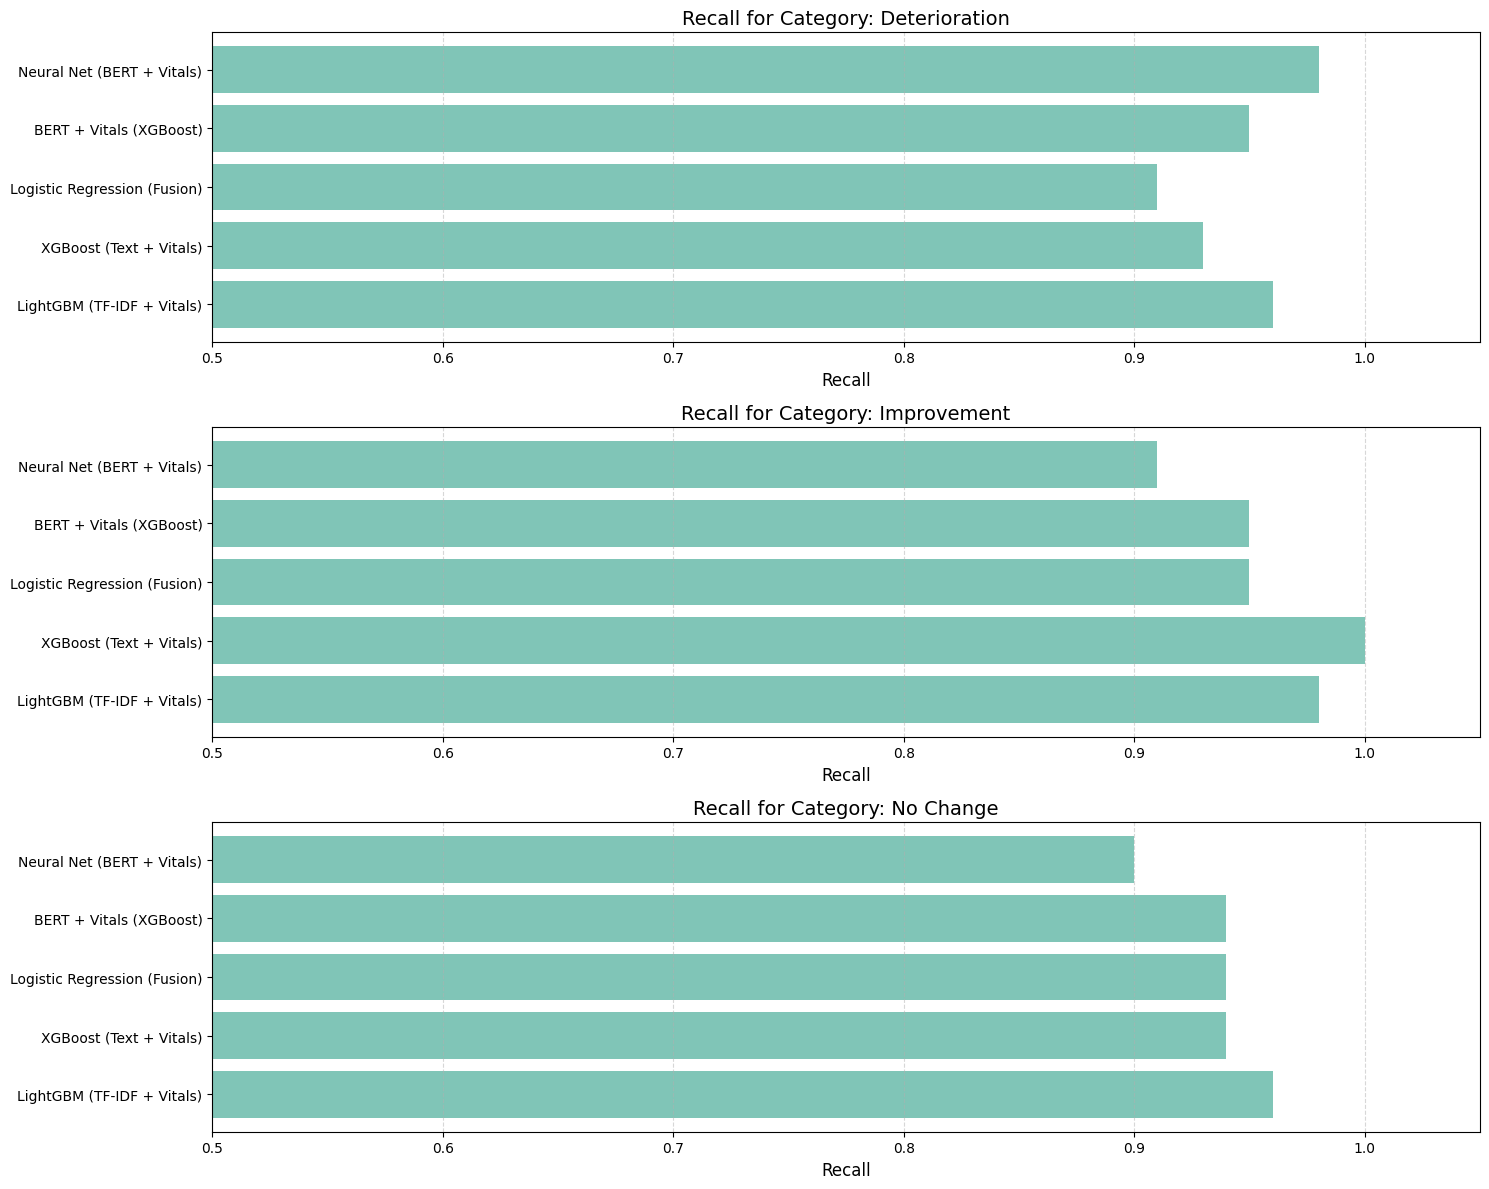

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


recall_by_category = pd.DataFrame([
    {"Model": "LightGBM (TF-IDF + Vitals)", "Deterioration": 0.96, "Improvement": 0.98, "No Change": 0.96},
    {"Model": "XGBoost (Text + Vitals)", "Deterioration": 0.93, "Improvement": 1.00, "No Change": 0.94},
    {"Model": "Logistic Regression (Fusion)", "Deterioration": 0.91, "Improvement": 0.95, "No Change": 0.94},
    {"Model": "BERT + Vitals (XGBoost)", "Deterioration": 0.95, "Improvement": 0.95, "No Change": 0.94},
    {"Model": "Neural Net (BERT + Vitals)", "Deterioration": 0.98, "Improvement": 0.91, "No Change": 0.90}
])


categories = ["Deterioration", "Improvement", "No Change"]

plt.figure(figsize=(15, 12))
for i, cat in enumerate(categories):
    plt.subplot(3, 1, i + 1)
    plt.barh(recall_by_category["Model"], recall_by_category[cat], color="#80c5b7")
    plt.title(f"Recall for Category: {cat}", fontsize=14)
    plt.xlabel("Recall", fontsize=12)
    plt.xlim(0.5, 1.05)
    plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


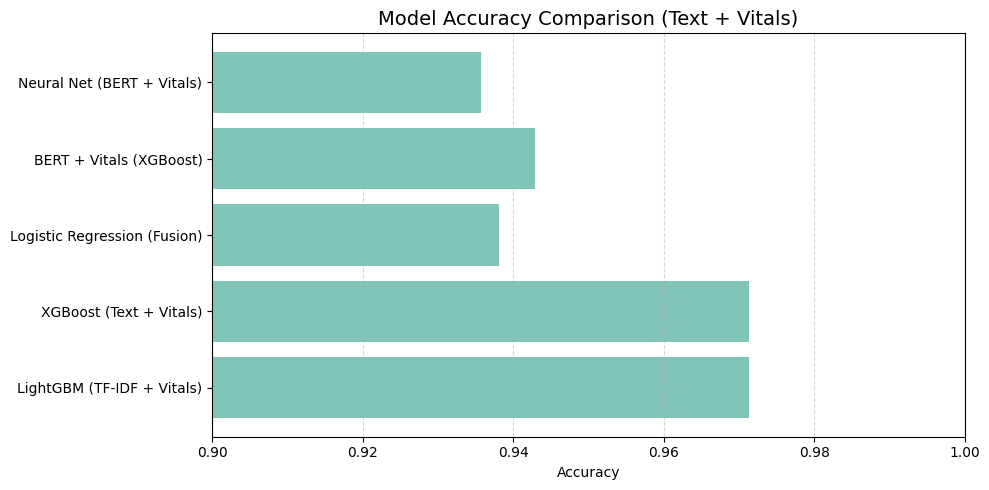

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Accuracy table by combined model
accuracy_data = pd.DataFrame({
    "Model": [
        "LightGBM (TF-IDF + Vitals)",
        "XGBoost (Text + Vitals)",
        "Logistic Regression (Fusion)",
        "BERT + Vitals (XGBoost)",
        "Neural Net (BERT + Vitals)"
    ],
    "Accuracy": [0.9714, 0.9714, 0.9381, 0.9429, 0.9357]
})

# comparison graph
plt.figure(figsize=(10, 5))
plt.barh(accuracy_data["Model"], accuracy_data["Accuracy"], color="#80c5b7")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison (Text + Vitals)", fontsize=14)
plt.xlim(0.9, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


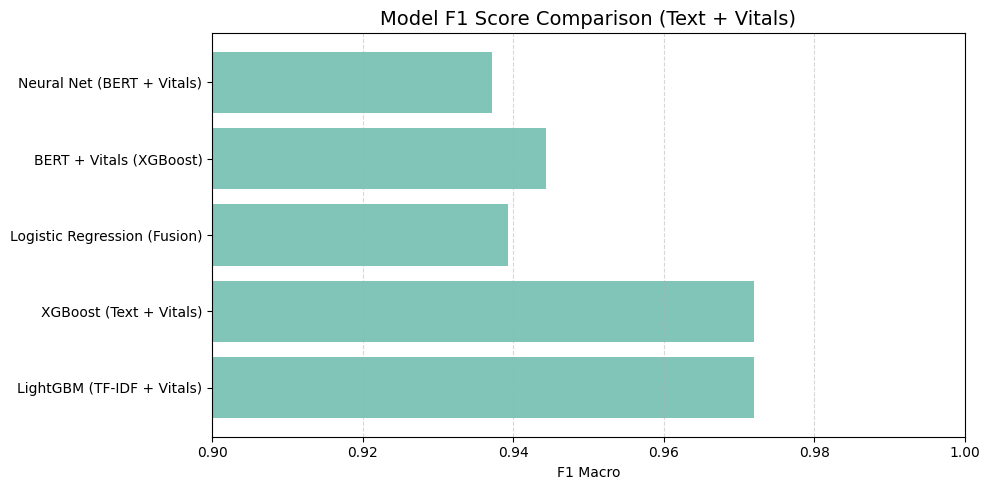

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# F1 table by combined model
f1_data = pd.DataFrame({
    "Model": [
        "LightGBM (TF-IDF + Vitals)",
        "XGBoost (Text + Vitals)",
        "Logistic Regression (Fusion)",
        "BERT + Vitals (XGBoost)",
        "Neural Net (BERT + Vitals)"
    ],
    "F1": [0.9720, 0.9720, 0.9393, 0.9444, 0.9372]
})

# F1 graph
plt.figure(figsize=(10, 5))
plt.barh(f1_data["Model"], f1_data["F1"], color="#80c5b7")
plt.xlabel("F1 Macro")
plt.title("Model F1 Score Comparison (Text + Vitals)", fontsize=14)
plt.xlim(0.9, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


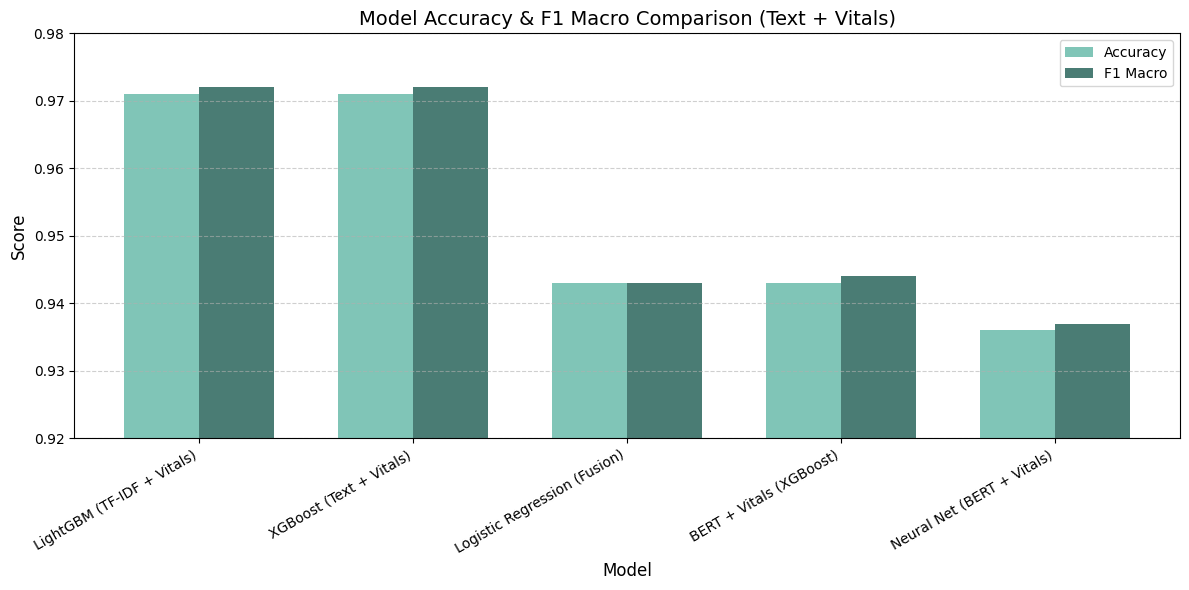

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Model": [
        "LightGBM (TF-IDF + Vitals)",
        "XGBoost (Text + Vitals)",
        "Logistic Regression (Fusion)",
        "BERT + Vitals (XGBoost)",
        "Neural Net (BERT + Vitals)"
    ],
    "Accuracy": [0.971, 0.971, 0.943, 0.943, 0.936],
    "F1 Macro": [0.972, 0.972, 0.943, 0.944, 0.937]
}

df = pd.DataFrame(data)

x = df["Model"]
accuracy = df["Accuracy"]
f1_macro = df["F1 Macro"]

bar_width = 0.35
index = range(len(x))

plt.figure(figsize=(12, 6))
plt.bar(index, accuracy, bar_width, label='Accuracy', color='#80c5b7')
plt.bar([i + bar_width for i in index], f1_macro, bar_width, label='F1 Macro', color='#4a7c74')

plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Accuracy & F1 Macro Comparison (Text + Vitals)', fontsize=14)
plt.xticks([i + bar_width / 2 for i in index], x, rotation=30, ha='right')
plt.ylim(0.92, 0.98)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


## Simulated Dialogues – Model Explanation

To better demonstrate how the model works, we created two types of simulated dialogues.  
- The first uses a real patient example with pre-written reasoning and outcome.  
- The second dynamically runs a trained model (LightGBM or BERT) on real patient data from `df_model_final`,  combining clinical text and vital sign deltas to predict the patient’s status.  

These simulations help visualize the input and decision process of the model in a user-friendly way.


In [ ]:
file_path = '/content/drive/MyDrive/patient_dataset.csv'
df1 = pd.read_csv(file_path)

def simulate_dialogue_from_dataset(index, df1):
    row = df1.iloc[index]

    print("="*60)
    print(" Patient - Day 1:")
    print(f"{row['day1_note']}\n")

    print(" Patient - Day 2:")
    print(f"{row['day2_note']}\n")

    print(" Model Reasoning (Pre-written):")
    print(f"{row['reasoning']}\n")

    print(" Status Label:")
    print(f"**{row['change'].capitalize()}**")
    print("="*60)

# example:
simulate_dialogue_from_dataset(6, df1)


 Patient - Day 1:
Today I noticed the redness on my arm isn't as dark as yesterday, and the swelling seems to be going down a bit. Vitals: HR 82, BP 128/82, Temp 37.2°C, RR 18.

 Patient - Day 2:
The itching has reduced a lot and the area looks less inflamed. I feel more comfortable moving around. Vitals: HR 80, BP 125/80, Temp 36.8°C, RR 16.

 Model Reasoning (Pre-written):
The reduction in redness and swelling, along with decreased itching, suggest healing of the skin infection. This is supported by stable vital signs indicating no acute distress or ongoing infection.

 Status Label:
**Improvement**


In [ ]:
def simulate_dialogue_from_row(index, df, model, tokenizer=None):
    """
    Simulates a dialogue for a single patient case from df_model_final.
    Retrieves the combined_text and vital deltas, runs prediction,
    and compares it with the actual target label.
    """
    print(" Starting simulate_dialogue_from_row")

    row = df.iloc[index]

    text_input = row['combined_text']
    vitals_input = [
        row['HR_diff'],
        row['RR_diff'],
        row['Temp_diff'],
        row['BP_SYS_diff'],
        row['BP_DIA_diff']
    ]

    print("="*60)
    print(f" Simulated Patient (row #{index})")
    print(" Combined Text Report:")
    print(text_input)

    print("\n Vital Signs (Delta):")
    for name, val in zip(['HR_diff', 'RR_diff', 'Temp_diff', 'BP_SYS_diff', 'BP_DIA_diff'], vitals_input):
        print(f"{name}: {val}")

    print("\n Model Prediction:")

    if tokenizer:
        # BERT-based model (not applicable to LightGBM)
        inputs = tokenizer(text_input, return_tensors="tf", padding=True, truncation=True)
        vitals_tensor = tf.convert_to_tensor([vitals_input], dtype=tf.float32)
        outputs = model([inputs['input_ids'], inputs['attention_mask'], vitals_tensor])
        pred_class = tf.argmax(outputs.logits, axis=1).numpy()[0]
    else:
        # TF-IDF + LightGBM/XGBoost
        text_vector = tfidf.transform([text_input])
        vitals_array = np.array(vitals_input).reshape(1, -1)
        combined_input = np.hstack([text_vector.toarray(), vitals_array])
        pred_class = model.predict(combined_input)[0]

    label_map = {0: "No Change", 1: "Improvement", 2: "Deterioration"}
    print(f" Predicted Status: {label_map[pred_class]}")

    # Compare with true label if available
    if 'target' in df.columns:
        true_label = row['target']
        correct = (true_label == pred_class)
        print(f"\n True Label: {label_map[true_label]}")
        print(f" Model {'correctly' if correct else 'incorrectly'} classified this case.")

    print("="*60)
import random

# Filter only patients with actual change (target != 0)
subset = df_model_final[df_model_final['target'] != 0]
random_index = random.choice(subset.index.tolist())

# Run the simulation
simulate_dialogue_from_row(
    index=random_index,
    df=df_model_final,
    model=model_lgbm,     # or model_xgb if applicable
    tokenizer=None        # only used for BERT-based models
)


 Starting simulate_dialogue_from_row
 Simulated Patient (row #239)
 Combined Text Report:
Today I'm feeling a bit tired and my legs are a little swollen. I've been trying to take it easy and stay off my feet when I can. Breathing is a bit tough, but I'm managing okay. My heart rate is 78, blood pressure is 135/85, temperature is 36.7°C, and respiratory rate is 22. [SEP] Still feeling pretty similar today. The swelling in my legs hasn't really gone down, but it's not getting any worse either. Breathing is about the same as yesterday. My heart rate is 80, blood pressure is 138/87, temperature is 36.8°C, and respiratory rate is 22.

 Vital Signs (Delta):
HR_diff: 0.6219512195121951
RR_diff: 0.46200607902735563
Temp_diff: 0.03026113671274984
BP_SYS_diff: -0.7012195121951219
BP_DIA_diff: -0.5213414634146342

 Model Prediction:
 Predicted Status: Deterioration

 True Label: Deterioration
 Model correctly classified this case.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
